In [1]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [2]:
in_dir = '../data/two_years_each/train_val_consistent'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

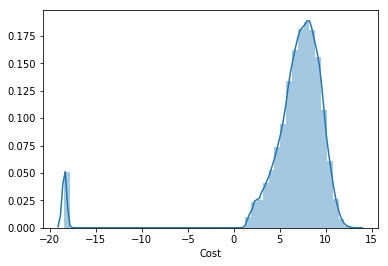

In [3]:
sns.distplot(np.log(df_train_Y['Cost'] + 0.00000001))
plt.plot()

In [4]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['Cost']:
    df_train_Y['Cost_log'] = df_train_Y['Cost'].apply(log)
    df_val_Y['Cost_log'] = df_val_Y['Cost'].apply(log)

### データ構造転換

In [5]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['Cost_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['Cost_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化

In [6]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=100, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['SalesRyutsu'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
optimize()

Training with params:                                                                                                  
{'alpha': 1.6372684702594043e-08, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.3975007674302266e-08, 'lambda': 0.13930593420191476, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5.499742828678817, 'n_estimators': 756.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:7.09875	eval-rmse:6.97151                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.52093	eval-rmse:6.35545                                                                               

[2]	train-rmse:6.0087	eval-rmse:5.80907                                                                          

[62]	train-rmse:2.18141	eval-rmse:2.35                                                                                 

[63]	train-rmse:2.17176	eval-rmse:2.35119                                                                              

[64]	train-rmse:2.16555	eval-rmse:2.35187                                                                              

[65]	train-rmse:2.14995	eval-rmse:2.35013                                                                              

Stopping. Best iteration:                                                                                              
[45]	train-rmse:2.32692	eval-rmse:2.33809


loss: 172068212.10424486                                                                                               
Training with params:                                                                                                  
{'alpha': 1.7938660994834084e-07, 'colsample_bytree': 0.7000000000000001, 'gamma': 1.3511306620173776e-07, 'lamb

[16]	train-rmse:2.53197	eval-rmse:2.36423                                                                              

[17]	train-rmse:2.49453	eval-rmse:2.3614                                                                               

[18]	train-rmse:2.47114	eval-rmse:2.37127                                                                              

[19]	train-rmse:2.43874	eval-rmse:2.37962                                                                              

[20]	train-rmse:2.41668	eval-rmse:2.38728                                                                              

[21]	train-rmse:2.39847	eval-rmse:2.39564                                                                              

[22]	train-rmse:2.37648	eval-rmse:2.3853                                                                               

[23]	train-rmse:2.36609	eval-rmse:2.38783                                                                              

[24]	train-rmse:2.35682	eval-rms

[38]	train-rmse:2.68487	eval-rmse:2.34884                                                                              

[39]	train-rmse:2.67611	eval-rmse:2.34654                                                                              

[40]	train-rmse:2.66537	eval-rmse:2.3458                                                                               

[41]	train-rmse:2.65561	eval-rmse:2.34758                                                                              

[42]	train-rmse:2.64833	eval-rmse:2.34579                                                                              

[43]	train-rmse:2.63735	eval-rmse:2.34639                                                                              

[44]	train-rmse:2.62887	eval-rmse:2.34672                                                                              

[45]	train-rmse:2.62401	eval-rmse:2.36194                                                                              

[46]	train-rmse:2.62089	eval-rms

[3]	train-rmse:3.60824	eval-rmse:2.79856                                                                               

[4]	train-rmse:3.42169	eval-rmse:2.55318                                                                               

[5]	train-rmse:3.32804	eval-rmse:2.44463                                                                               

[6]	train-rmse:3.27291	eval-rmse:2.38334                                                                               

[7]	train-rmse:3.24167	eval-rmse:2.35768                                                                               

[8]	train-rmse:3.2167	eval-rmse:2.33996                                                                                

[9]	train-rmse:3.20059	eval-rmse:2.33742                                                                               

[10]	train-rmse:3.18787	eval-rmse:2.33276                                                                              

[11]	train-rmse:3.17517	eval-rms

Stopping. Best iteration:                                                                                              
[7]	train-rmse:3.04035	eval-rmse:2.37558


loss: 175110832.87292397                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00023107213063930108, 'colsample_bytree': 0.7000000000000001, 'gamma': 1.4056057248157498e-08, 'lambda': 0.0011727732461489478, 'learning_rate': 0.35000000000000003, 'max_depth': 5, 'min_child_weight': 9.102761539359703, 'n_estimators': 284.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:5.63317	eval-rmse:5.31067                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't impro

[23]	train-rmse:3.15172	eval-rmse:2.37755                                                                              

[24]	train-rmse:3.14718	eval-rmse:2.37552                                                                              

[25]	train-rmse:3.14256	eval-rmse:2.3753                                                                               

[26]	train-rmse:3.13787	eval-rmse:2.37811                                                                              

[27]	train-rmse:3.13158	eval-rmse:2.37208                                                                              

[28]	train-rmse:3.12686	eval-rmse:2.37942                                                                              

[29]	train-rmse:3.12313	eval-rmse:2.37721                                                                              

[30]	train-rmse:3.11822	eval-rmse:2.3771                                                                               

[31]	train-rmse:3.11447	eval-rms

[51]	train-rmse:2.94325	eval-rmse:2.3614                                                                               

[52]	train-rmse:2.93495	eval-rmse:2.35436                                                                              

[53]	train-rmse:2.92626	eval-rmse:2.34987                                                                              

[54]	train-rmse:2.91852	eval-rmse:2.34691                                                                              

[55]	train-rmse:2.90972	eval-rmse:2.34295                                                                              

[56]	train-rmse:2.90104	eval-rmse:2.34129                                                                              

[57]	train-rmse:2.8943	eval-rmse:2.33695                                                                               

[58]	train-rmse:2.88685	eval-rmse:2.33509                                                                              

[59]	train-rmse:2.88	eval-rmse:2

[12]	train-rmse:2.72855	eval-rmse:2.52965                                                                              

[13]	train-rmse:2.69827	eval-rmse:2.54115                                                                              

[14]	train-rmse:2.68125	eval-rmse:2.55461                                                                              

[15]	train-rmse:2.65598	eval-rmse:2.55493                                                                              

[16]	train-rmse:2.63904	eval-rmse:2.54496                                                                              

[17]	train-rmse:2.61339	eval-rmse:2.54451                                                                              

[18]	train-rmse:2.56798	eval-rmse:2.54633                                                                              

[19]	train-rmse:2.5515	eval-rmse:2.54943                                                                               

[20]	train-rmse:2.52979	eval-rms

[10]	train-rmse:2.65666	eval-rmse:2.40366                                                                              

[11]	train-rmse:2.62013	eval-rmse:2.41041                                                                              

[12]	train-rmse:2.60564	eval-rmse:2.4081                                                                               

[13]	train-rmse:2.57144	eval-rmse:2.40207                                                                              

[14]	train-rmse:2.54829	eval-rmse:2.40762                                                                              

[15]	train-rmse:2.52029	eval-rmse:2.41826                                                                              

[16]	train-rmse:2.49997	eval-rmse:2.4173                                                                               

[17]	train-rmse:2.47712	eval-rmse:2.41224                                                                              

[18]	train-rmse:2.4584	eval-rmse

[3]	train-rmse:6.62298	eval-rmse:6.40682                                                                               

[4]	train-rmse:6.38229	eval-rmse:6.13219                                                                               

[5]	train-rmse:6.15653	eval-rmse:5.87439                                                                               

[6]	train-rmse:5.94597	eval-rmse:5.6357                                                                                

[7]	train-rmse:5.74738	eval-rmse:5.4049                                                                                

[8]	train-rmse:5.56212	eval-rmse:5.1878                                                                                

[9]	train-rmse:5.38998	eval-rmse:4.98963                                                                               

[10]	train-rmse:5.22834	eval-rmse:4.79771                                                                              

[11]	train-rmse:5.07803	eval-rms

[70]	train-rmse:3.25456	eval-rmse:2.34447                                                                              

[71]	train-rmse:3.25224	eval-rmse:2.34321                                                                              

[72]	train-rmse:3.25046	eval-rmse:2.34289                                                                              

[73]	train-rmse:3.24814	eval-rmse:2.34231                                                                              

[74]	train-rmse:3.24603	eval-rmse:2.34304                                                                              

[75]	train-rmse:3.24426	eval-rmse:2.34181                                                                              

[76]	train-rmse:3.24253	eval-rmse:2.34138                                                                              

[77]	train-rmse:3.24112	eval-rmse:2.33984                                                                              

[78]	train-rmse:3.23895	eval-rms

{'alpha': 0.00010504961078307809, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.00010531441536073223, 'lambda': 0.9328686649572729, 'learning_rate': 0.42500000000000004, 'max_depth': 6, 'min_child_weight': 0.658793423057999, 'n_estimators': 662.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:5.19826	eval-rmse:4.79985                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:3.97586	eval-rmse:3.34995                                                                               

[2]	train-rmse:3.44979	eval-rmse:2.71402                                                                               

[3]	train-rmse:3.22652	eval-rmse:2.47283                                          

[28]	train-rmse:2.94654	eval-rmse:2.39465                                                                              

[29]	train-rmse:2.93662	eval-rmse:2.39409                                                                              

Stopping. Best iteration:                                                                                              
[9]	train-rmse:3.11862	eval-rmse:2.33895


loss: 161363133.3096179                                                                                                
Training with params:                                                                                                  
{'alpha': 0.6880134466305411, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.005489668751294421, 'lambda': 6.324024665982258e-06, 'learning_rate': 0.225, 'max_depth': 4, 'min_child_weight': 0.5266293013493667, 'n_estimators': 823.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:6.3733	eval-rmse:6.12427                    

[17]	train-rmse:3.48713	eval-rmse:2.6017                                                                               

[18]	train-rmse:3.45135	eval-rmse:2.55431                                                                              

[19]	train-rmse:3.42079	eval-rmse:2.51567                                                                              

[20]	train-rmse:3.39535	eval-rmse:2.48506                                                                              

[21]	train-rmse:3.37392	eval-rmse:2.45817                                                                              

[22]	train-rmse:3.35533	eval-rmse:2.43871                                                                              

[23]	train-rmse:3.34016	eval-rmse:2.42187                                                                              

[24]	train-rmse:3.32616	eval-rmse:2.40757                                                                              

[25]	train-rmse:3.31568	eval-rms

[84]	train-rmse:3.1532	eval-rmse:2.33115                                                                               

[85]	train-rmse:3.15156	eval-rmse:2.33117                                                                              

[86]	train-rmse:3.15042	eval-rmse:2.32986                                                                              

[87]	train-rmse:3.14929	eval-rmse:2.32908                                                                              

[88]	train-rmse:3.148	eval-rmse:2.32923                                                                                

[89]	train-rmse:3.14698	eval-rmse:2.32842                                                                              

[90]	train-rmse:3.14529	eval-rmse:2.32856                                                                              

[91]	train-rmse:3.14318	eval-rmse:2.32271                                                                              

[92]	train-rmse:3.14221	eval-rms

[45]	train-rmse:3.36494	eval-rmse:2.45422                                                                              

[46]	train-rmse:3.3566	eval-rmse:2.44422                                                                               

[47]	train-rmse:3.34895	eval-rmse:2.43505                                                                              

[48]	train-rmse:3.34138	eval-rmse:2.4265                                                                               

[49]	train-rmse:3.33448	eval-rmse:2.41905                                                                              

[50]	train-rmse:3.32829	eval-rmse:2.41191                                                                              

[51]	train-rmse:3.32259	eval-rmse:2.40484                                                                              

[52]	train-rmse:3.3176	eval-rmse:2.39946                                                                               

[53]	train-rmse:3.31268	eval-rms

[6]	train-rmse:6.76073	eval-rmse:6.56389                                                                               

[7]	train-rmse:6.63553	eval-rmse:6.42283                                                                               

[8]	train-rmse:6.51505	eval-rmse:6.28608                                                                               

[9]	train-rmse:6.39829	eval-rmse:6.15247                                                                               

[10]	train-rmse:6.28463	eval-rmse:6.0234                                                                               

[11]	train-rmse:6.17497	eval-rmse:5.89919                                                                              

[12]	train-rmse:6.06825	eval-rmse:5.77692                                                                              

[13]	train-rmse:5.9655	eval-rmse:5.6583                                                                                

[14]	train-rmse:5.86548	eval-rms

[73]	train-rmse:3.49448	eval-rmse:2.62255                                                                              

[74]	train-rmse:3.48475	eval-rmse:2.60988                                                                              

[75]	train-rmse:3.47567	eval-rmse:2.59798                                                                              

[76]	train-rmse:3.46708	eval-rmse:2.58635                                                                              

[77]	train-rmse:3.45887	eval-rmse:2.57585                                                                              

[78]	train-rmse:3.45096	eval-rmse:2.56518                                                                              

[79]	train-rmse:3.44318	eval-rmse:2.55443                                                                              

[80]	train-rmse:3.43594	eval-rmse:2.54471                                                                              

[81]	train-rmse:3.42906	eval-rms

[34]	train-rmse:3.20677	eval-rmse:2.3331                                                                               

[35]	train-rmse:3.2038	eval-rmse:2.3319                                                                                

[36]	train-rmse:3.20155	eval-rmse:2.33184                                                                              

[37]	train-rmse:3.19901	eval-rmse:2.33266                                                                              

[38]	train-rmse:3.19661	eval-rmse:2.33266                                                                              

[39]	train-rmse:3.19358	eval-rmse:2.3343                                                                               

[40]	train-rmse:3.19211	eval-rmse:2.33555                                                                              

[41]	train-rmse:3.18823	eval-rmse:2.33381                                                                              

[42]	train-rmse:3.18566	eval-rms

[41]	train-rmse:4.15019	eval-rmse:3.4796                                                                               

[42]	train-rmse:4.11395	eval-rmse:3.43414                                                                              

[43]	train-rmse:4.07925	eval-rmse:3.3891                                                                               

[44]	train-rmse:4.04565	eval-rmse:3.34601                                                                              

[45]	train-rmse:4.01354	eval-rmse:3.30533                                                                              

[46]	train-rmse:3.98267	eval-rmse:3.26608                                                                              

[47]	train-rmse:3.95304	eval-rmse:3.22741                                                                              

[48]	train-rmse:3.9251	eval-rmse:3.19157                                                                               

[49]	train-rmse:3.89787	eval-rms

[2]	train-rmse:7.30086	eval-rmse:7.16839                                                                               

[3]	train-rmse:7.15925	eval-rmse:7.0102                                                                                

[4]	train-rmse:7.02204	eval-rmse:6.85654                                                                               

[5]	train-rmse:6.88904	eval-rmse:6.70689                                                                               

[6]	train-rmse:6.76072	eval-rmse:6.56388                                                                               

[7]	train-rmse:6.63553	eval-rmse:6.42282                                                                               

[8]	train-rmse:6.51504	eval-rmse:6.28607                                                                               

[9]	train-rmse:6.39827	eval-rmse:6.15247                                                                               

[10]	train-rmse:6.28461	eval-rms

[69]	train-rmse:3.53636	eval-rmse:2.67833                                                                              

[70]	train-rmse:3.52519	eval-rmse:2.66312                                                                              

[71]	train-rmse:3.51462	eval-rmse:2.64865                                                                              

[72]	train-rmse:3.50434	eval-rmse:2.63557                                                                              

[73]	train-rmse:3.49444	eval-rmse:2.62253                                                                              

[74]	train-rmse:3.4847	eval-rmse:2.60987                                                                               

[75]	train-rmse:3.47562	eval-rmse:2.59796                                                                              

[76]	train-rmse:3.46704	eval-rmse:2.58634                                                                              

[77]	train-rmse:3.45883	eval-rms

[30]	train-rmse:3.17263	eval-rmse:2.38762                                                                              

[31]	train-rmse:3.16986	eval-rmse:2.38518                                                                              

[32]	train-rmse:3.1663	eval-rmse:2.38383                                                                               

[33]	train-rmse:3.16278	eval-rmse:2.38763                                                                              

[34]	train-rmse:3.15962	eval-rmse:2.38709                                                                              

[35]	train-rmse:3.15568	eval-rmse:2.39161                                                                              

[36]	train-rmse:3.15232	eval-rmse:2.39026                                                                              

[37]	train-rmse:3.14917	eval-rmse:2.39017                                                                              

[38]	train-rmse:3.14672	eval-rms

[47]	train-rmse:3.17442	eval-rmse:2.33002                                                                              

[48]	train-rmse:3.17295	eval-rmse:2.33119                                                                              

[49]	train-rmse:3.17017	eval-rmse:2.32884                                                                              

[50]	train-rmse:3.1686	eval-rmse:2.32884                                                                               

[51]	train-rmse:3.16642	eval-rmse:2.32945                                                                              

[52]	train-rmse:3.16447	eval-rmse:2.33391                                                                              

[53]	train-rmse:3.16347	eval-rmse:2.33871                                                                              

[54]	train-rmse:3.1612	eval-rmse:2.33702                                                                               

[55]	train-rmse:3.16012	eval-rms

[37]	train-rmse:4.18369	eval-rmse:3.62858                                                                              

[38]	train-rmse:4.13876	eval-rmse:3.57492                                                                              

[39]	train-rmse:4.09535	eval-rmse:3.52259                                                                              

[40]	train-rmse:4.05359	eval-rmse:3.47264                                                                              

[41]	train-rmse:4.01294	eval-rmse:3.42466                                                                              

[42]	train-rmse:3.97399	eval-rmse:3.37776                                                                              

[43]	train-rmse:3.9367	eval-rmse:3.33253                                                                               

[44]	train-rmse:3.90067	eval-rmse:3.28941                                                                              

[45]	train-rmse:3.86613	eval-rms

[0]	train-rmse:7.28872	eval-rmse:7.15322                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.86737	eval-rmse:6.68174                                                                               

[2]	train-rmse:6.48609	eval-rmse:6.24686                                                                               

[3]	train-rmse:6.13874	eval-rmse:5.84913                                                                               

[4]	train-rmse:5.82447	eval-rmse:5.48786                                                                               

[5]	train-rmse:5.54056	eval-rmse:5.15848                                                                               

[6]	train-rmse:5.28478	eval-rms

[65]	train-rmse:3.20874	eval-rmse:2.32509                                                                              

[66]	train-rmse:3.20745	eval-rmse:2.3254                                                                               

[67]	train-rmse:3.20582	eval-rmse:2.32455                                                                              

[68]	train-rmse:3.20393	eval-rmse:2.3247                                                                               

[69]	train-rmse:3.20286	eval-rmse:2.32405                                                                              

[70]	train-rmse:3.20077	eval-rmse:2.32547                                                                              

[71]	train-rmse:3.19966	eval-rmse:2.32489                                                                              

[72]	train-rmse:3.19799	eval-rmse:2.32492                                                                              

[73]	train-rmse:3.19703	eval-rms

[26]	train-rmse:3.23309	eval-rmse:2.37393                                                                              

[27]	train-rmse:3.22361	eval-rmse:2.36389                                                                              

[28]	train-rmse:3.21589	eval-rmse:2.35622                                                                              

[29]	train-rmse:3.20816	eval-rmse:2.34998                                                                              

[30]	train-rmse:3.20169	eval-rmse:2.34502                                                                              

[31]	train-rmse:3.19509	eval-rmse:2.34067                                                                              

[32]	train-rmse:3.18904	eval-rmse:2.33749                                                                              

[33]	train-rmse:3.1845	eval-rmse:2.335                                                                                 

[34]	train-rmse:3.1797	eval-rmse

[5]	train-rmse:3.92616	eval-rmse:3.60724                                                                               

[6]	train-rmse:3.62711	eval-rmse:3.30405                                                                               

[7]	train-rmse:3.38749	eval-rmse:3.07043                                                                               

[8]	train-rmse:3.19136	eval-rmse:2.88816                                                                               

[9]	train-rmse:3.03825	eval-rmse:2.75293                                                                               

[10]	train-rmse:2.91604	eval-rmse:2.65018                                                                              

[11]	train-rmse:2.81997	eval-rmse:2.57321                                                                              

[12]	train-rmse:2.74322	eval-rmse:2.51505                                                                              

[13]	train-rmse:2.67941	eval-rms

[21]	train-rmse:2.54335	eval-rmse:2.41714                                                                              

[22]	train-rmse:2.5341	eval-rmse:2.41671                                                                               

[23]	train-rmse:2.52749	eval-rmse:2.41764                                                                              

[24]	train-rmse:2.51636	eval-rmse:2.42107                                                                              

[25]	train-rmse:2.50068	eval-rmse:2.42227                                                                              

[26]	train-rmse:2.49069	eval-rmse:2.42086                                                                              

[27]	train-rmse:2.478	eval-rmse:2.42516                                                                                

[28]	train-rmse:2.46466	eval-rmse:2.42258                                                                              

[29]	train-rmse:2.44796	eval-rms

[47]	train-rmse:2.39221	eval-rmse:2.3499                                                                               

[48]	train-rmse:2.38256	eval-rmse:2.34734                                                                              

[49]	train-rmse:2.37517	eval-rmse:2.34781                                                                              

[50]	train-rmse:2.36688	eval-rmse:2.34926                                                                              

[51]	train-rmse:2.35858	eval-rmse:2.34814                                                                              

[52]	train-rmse:2.34964	eval-rmse:2.34652                                                                              

[53]	train-rmse:2.3396	eval-rmse:2.34278                                                                               

[54]	train-rmse:2.33416	eval-rmse:2.34357                                                                              

[55]	train-rmse:2.32359	eval-rms

[32]	train-rmse:3.00646	eval-rmse:2.37252                                                                              

[33]	train-rmse:2.99958	eval-rmse:2.37059                                                                              

[34]	train-rmse:2.99333	eval-rmse:2.37386                                                                              

[35]	train-rmse:2.99066	eval-rmse:2.37169                                                                              

[36]	train-rmse:2.98545	eval-rmse:2.37284                                                                              

[37]	train-rmse:2.9829	eval-rmse:2.37252                                                                               

[38]	train-rmse:2.97756	eval-rmse:2.37999                                                                              

[39]	train-rmse:2.96947	eval-rmse:2.37772                                                                              

[40]	train-rmse:2.96575	eval-rms

[50]	train-rmse:3.19031	eval-rmse:2.3264                                                                               

[51]	train-rmse:3.18899	eval-rmse:2.32827                                                                              

[52]	train-rmse:3.18636	eval-rmse:2.3249                                                                               

[53]	train-rmse:3.18411	eval-rmse:2.32651                                                                              

[54]	train-rmse:3.18165	eval-rmse:2.32501                                                                              

[55]	train-rmse:3.17968	eval-rmse:2.32391                                                                              

[56]	train-rmse:3.17655	eval-rmse:2.32213                                                                              

[57]	train-rmse:3.17602	eval-rmse:2.32663                                                                              

[58]	train-rmse:3.17408	eval-rms

loss: 176263709.3761706                                                                                                
Training with params:                                                                                                  
{'alpha': 0.10235976655641593, 'colsample_bytree': 0.75, 'gamma': 0.050025320701723004, 'lambda': 0.0034723272090395703, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 1.9439640162488039, 'n_estimators': 478.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:6.52497	eval-rmse:6.30137                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.59432	eval-rmse:5.23562                                                                               

[2]	train

[0]	train-rmse:7.28872	eval-rmse:7.15322                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.86737	eval-rmse:6.68174                                                                               

[2]	train-rmse:6.48849	eval-rmse:6.25263                                                                               

[3]	train-rmse:6.14078	eval-rmse:5.85355                                                                               

[4]	train-rmse:5.82632	eval-rmse:5.4924                                                                                

[5]	train-rmse:5.54258	eval-rmse:5.16325                                                                               

[6]	train-rmse:5.28745	eval-rms

[65]	train-rmse:3.20912	eval-rmse:2.33329                                                                              

[66]	train-rmse:3.20742	eval-rmse:2.33314                                                                              

[67]	train-rmse:3.20637	eval-rmse:2.33231                                                                              

[68]	train-rmse:3.20551	eval-rmse:2.33248                                                                              

[69]	train-rmse:3.20431	eval-rmse:2.33343                                                                              

[70]	train-rmse:3.20311	eval-rmse:2.33322                                                                              

[71]	train-rmse:3.20202	eval-rmse:2.33256                                                                              

[72]	train-rmse:3.20046	eval-rmse:2.33421                                                                              

[73]	train-rmse:3.19936	eval-rms

[26]	train-rmse:4.7901	eval-rmse:4.35311                                                                               

[27]	train-rmse:4.7231	eval-rmse:4.27498                                                                               

[28]	train-rmse:4.65825	eval-rmse:4.1998                                                                               

[29]	train-rmse:4.59556	eval-rmse:4.12695                                                                              

[30]	train-rmse:4.53509	eval-rmse:4.05648                                                                              

[31]	train-rmse:4.47689	eval-rmse:3.98843                                                                              

[32]	train-rmse:4.42015	eval-rmse:3.92271                                                                              

[33]	train-rmse:4.36598	eval-rmse:3.85835                                                                              

[34]	train-rmse:4.31343	eval-rms

[93]	train-rmse:3.10275	eval-rmse:2.40256                                                                              

[94]	train-rmse:3.097	eval-rmse:2.39766                                                                                

[95]	train-rmse:3.09179	eval-rmse:2.3932                                                                               

[96]	train-rmse:3.08657	eval-rmse:2.38814                                                                              

[97]	train-rmse:3.08116	eval-rmse:2.38397                                                                              

[98]	train-rmse:3.07603	eval-rmse:2.38029                                                                              

[99]	train-rmse:3.07085	eval-rmse:2.37602                                                                              

loss: 105940593.16788788                                                                                               
Training with params:            

[4]	train-rmse:5.34787	eval-rmse:4.92795                                                                               

[5]	train-rmse:5.03462	eval-rmse:4.55849                                                                               

[6]	train-rmse:4.76465	eval-rmse:4.23667                                                                               

[7]	train-rmse:4.53192	eval-rmse:3.94911                                                                               

[8]	train-rmse:4.33221	eval-rmse:3.70171                                                                               

[9]	train-rmse:4.16367	eval-rmse:3.49344                                                                               

[10]	train-rmse:4.02019	eval-rmse:3.30959                                                                              

[11]	train-rmse:3.89926	eval-rmse:3.15008                                                                              

[12]	train-rmse:3.79719	eval-rms

[71]	train-rmse:3.17417	eval-rmse:2.34324                                                                              

[72]	train-rmse:3.17288	eval-rmse:2.34255                                                                              

[73]	train-rmse:3.17108	eval-rmse:2.34254                                                                              

[74]	train-rmse:3.16968	eval-rmse:2.34241                                                                              

[75]	train-rmse:3.16816	eval-rmse:2.34251                                                                              

[76]	train-rmse:3.16593	eval-rmse:2.34021                                                                              

[77]	train-rmse:3.16521	eval-rmse:2.33988                                                                              

[78]	train-rmse:3.1633	eval-rmse:2.33905                                                                               

[79]	train-rmse:3.16075	eval-rms

Stopping. Best iteration:                                                                                              
[29]	train-rmse:2.56847	eval-rmse:2.36662


loss: 166398360.61169735                                                                                               
Training with params:                                                                                                  
{'alpha': 0.8464263879134202, 'colsample_bytree': 0.8, 'gamma': 7.162818690006702e-05, 'lambda': 0.0016401815274736356, 'learning_rate': 0.225, 'max_depth': 3, 'min_child_weight': 7.084801103593798, 'n_estimators': 216.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:6.39355	eval-rmse:6.1443                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                               

[15]	train-rmse:4.26772	eval-rmse:3.96516                                                                              

[16]	train-rmse:4.14391	eval-rmse:3.83602                                                                              

[17]	train-rmse:4.02554	eval-rmse:3.71258                                                                              

[18]	train-rmse:3.91402	eval-rmse:3.60076                                                                              

[19]	train-rmse:3.81358	eval-rmse:3.49534                                                                              

[20]	train-rmse:3.71969	eval-rmse:3.39732                                                                              

[21]	train-rmse:3.63204	eval-rmse:3.31008                                                                              

[22]	train-rmse:3.55161	eval-rmse:3.22775                                                                              

[23]	train-rmse:3.47458	eval-rms

[82]	train-rmse:2.27346	eval-rmse:2.35788                                                                              

[83]	train-rmse:2.27118	eval-rmse:2.35769                                                                              

[84]	train-rmse:2.26311	eval-rmse:2.35707                                                                              

[85]	train-rmse:2.25496	eval-rmse:2.359                                                                                

[86]	train-rmse:2.25149	eval-rmse:2.35945                                                                              

[87]	train-rmse:2.24731	eval-rmse:2.35811                                                                              

[88]	train-rmse:2.24067	eval-rmse:2.35961                                                                              

[89]	train-rmse:2.23593	eval-rmse:2.35954                                                                              

[90]	train-rmse:2.22686	eval-rms

[16]	train-rmse:2.93524	eval-rmse:2.37359                                                                              

[17]	train-rmse:2.91748	eval-rmse:2.37403                                                                              

[18]	train-rmse:2.90666	eval-rmse:2.37674                                                                              

[19]	train-rmse:2.89737	eval-rmse:2.37571                                                                              

[20]	train-rmse:2.88798	eval-rmse:2.37595                                                                              

[21]	train-rmse:2.876	eval-rmse:2.38408                                                                                

[22]	train-rmse:2.85874	eval-rmse:2.38512                                                                              

[23]	train-rmse:2.84747	eval-rmse:2.38868                                                                              

[24]	train-rmse:2.83514	eval-rms

[4]	train-rmse:3.23364	eval-rmse:2.39934                                                                               

[5]	train-rmse:3.18038	eval-rmse:2.36687                                                                               

[6]	train-rmse:3.13907	eval-rmse:2.36078                                                                               

[7]	train-rmse:3.11529	eval-rmse:2.36324                                                                               

[8]	train-rmse:3.09677	eval-rmse:2.39325                                                                               

[9]	train-rmse:3.08604	eval-rmse:2.4175                                                                                

[10]	train-rmse:3.07104	eval-rmse:2.42161                                                                              

[11]	train-rmse:3.05344	eval-rmse:2.40943                                                                              

[12]	train-rmse:3.04769	eval-rms

[37]	train-rmse:3.09122	eval-rmse:2.35093                                                                              

[38]	train-rmse:3.08747	eval-rmse:2.35505                                                                              

[39]	train-rmse:3.0844	eval-rmse:2.35432                                                                               

[40]	train-rmse:3.08012	eval-rmse:2.36057                                                                              

[41]	train-rmse:3.07735	eval-rmse:2.36246                                                                              

[42]	train-rmse:3.07427	eval-rmse:2.36534                                                                              

[43]	train-rmse:3.07183	eval-rmse:2.3693                                                                               

[44]	train-rmse:3.07066	eval-rmse:2.36907                                                                              

[45]	train-rmse:3.06719	eval-rms

[39]	train-rmse:2.66886	eval-rmse:2.35175                                                                              

[40]	train-rmse:2.65523	eval-rmse:2.35079                                                                              

[41]	train-rmse:2.63915	eval-rmse:2.34492                                                                              

[42]	train-rmse:2.62852	eval-rmse:2.34403                                                                              

[43]	train-rmse:2.61906	eval-rmse:2.34168                                                                              

[44]	train-rmse:2.61019	eval-rmse:2.34981                                                                              

[45]	train-rmse:2.60186	eval-rmse:2.34585                                                                              

[46]	train-rmse:2.59605	eval-rmse:2.34486                                                                              

[47]	train-rmse:2.5873	eval-rmse

[13]	train-rmse:3.20249	eval-rmse:2.57334                                                                              

[14]	train-rmse:3.14317	eval-rmse:2.51466                                                                              

[15]	train-rmse:3.09861	eval-rmse:2.47314                                                                              

[16]	train-rmse:3.05455	eval-rmse:2.444                                                                                

[17]	train-rmse:3.02177	eval-rmse:2.40933                                                                              

[18]	train-rmse:2.99298	eval-rmse:2.38891                                                                              

[19]	train-rmse:2.9665	eval-rmse:2.3722                                                                                

[20]	train-rmse:2.9452	eval-rmse:2.35997                                                                               

[21]	train-rmse:2.92751	eval-rms

[2]	train-rmse:7.30056	eval-rmse:7.1677                                                                                

[3]	train-rmse:7.15918	eval-rmse:7.00957                                                                               

[4]	train-rmse:7.02193	eval-rmse:6.85586                                                                               

[5]	train-rmse:6.88916	eval-rmse:6.70632                                                                               

[6]	train-rmse:6.76085	eval-rmse:6.56336                                                                               

[7]	train-rmse:6.63566	eval-rmse:6.42206                                                                               

[8]	train-rmse:6.51514	eval-rmse:6.28402                                                                               

[9]	train-rmse:6.39848	eval-rmse:6.15172                                                                               

[10]	train-rmse:6.28476	eval-rms

[69]	train-rmse:3.53555	eval-rmse:2.67566                                                                              

[70]	train-rmse:3.52432	eval-rmse:2.66029                                                                              

[71]	train-rmse:3.51355	eval-rmse:2.64624                                                                              

[72]	train-rmse:3.5032	eval-rmse:2.63212                                                                               

[73]	train-rmse:3.49324	eval-rmse:2.61903                                                                              

[74]	train-rmse:3.4838	eval-rmse:2.60612                                                                               

[75]	train-rmse:3.47466	eval-rmse:2.59422                                                                              

[76]	train-rmse:3.46579	eval-rmse:2.58233                                                                              

[77]	train-rmse:3.45769	eval-rms

[30]	train-rmse:3.18242	eval-rmse:2.34701                                                                              

[31]	train-rmse:3.18003	eval-rmse:2.3465                                                                               

[32]	train-rmse:3.17759	eval-rmse:2.34648                                                                              

[33]	train-rmse:3.17538	eval-rmse:2.34693                                                                              

[34]	train-rmse:3.17059	eval-rmse:2.34782                                                                              

[35]	train-rmse:3.16919	eval-rmse:2.34779                                                                              

[36]	train-rmse:3.16634	eval-rmse:2.34711                                                                              

[37]	train-rmse:3.16309	eval-rmse:2.3501                                                                               

[38]	train-rmse:3.16158	eval-rms

[51]	train-rmse:3.25045	eval-rmse:2.3828                                                                               

[52]	train-rmse:3.24478	eval-rmse:2.37656                                                                              

[53]	train-rmse:3.23956	eval-rmse:2.36997                                                                              

[54]	train-rmse:3.23421	eval-rmse:2.3645                                                                               

[55]	train-rmse:3.22895	eval-rmse:2.35869                                                                              

[56]	train-rmse:3.22403	eval-rmse:2.35456                                                                              

[57]	train-rmse:3.21983	eval-rmse:2.35126                                                                              

[58]	train-rmse:3.21506	eval-rmse:2.34761                                                                              

[59]	train-rmse:3.21014	eval-rms

[12]	train-rmse:3.12121	eval-rmse:2.40102                                                                              

[13]	train-rmse:3.088	eval-rmse:2.37624                                                                                

[14]	train-rmse:3.0608	eval-rmse:2.36917                                                                               

[15]	train-rmse:3.03976	eval-rmse:2.36318                                                                              

[16]	train-rmse:3.02208	eval-rmse:2.3565                                                                               

[17]	train-rmse:3.00203	eval-rmse:2.35264                                                                              

[18]	train-rmse:2.99154	eval-rmse:2.34791                                                                              

[19]	train-rmse:2.9793	eval-rmse:2.34842                                                                               

[20]	train-rmse:2.97309	eval-rms

[30]	train-rmse:3.14018	eval-rmse:2.38167                                                                              

[31]	train-rmse:3.13873	eval-rmse:2.38272                                                                              

[32]	train-rmse:3.13686	eval-rmse:2.381                                                                                

[33]	train-rmse:3.1349	eval-rmse:2.38334                                                                               

[34]	train-rmse:3.13119	eval-rmse:2.38315                                                                              

[35]	train-rmse:3.12911	eval-rmse:2.38294                                                                              

[36]	train-rmse:3.1254	eval-rmse:2.38193                                                                               

Stopping. Best iteration:                                                                                              
[16]	train-rmse:3.20214	eval-rmse

[13]	train-rmse:3.14393	eval-rmse:2.32762                                                                              

[14]	train-rmse:3.12534	eval-rmse:2.33003                                                                              

[15]	train-rmse:3.11324	eval-rmse:2.32218                                                                              

[16]	train-rmse:3.10211	eval-rmse:2.31769                                                                              

[17]	train-rmse:3.09147	eval-rmse:2.32454                                                                              

[18]	train-rmse:3.08234	eval-rmse:2.32447                                                                              

[19]	train-rmse:3.07283	eval-rmse:2.32232                                                                              

[20]	train-rmse:3.06954	eval-rmse:2.32174                                                                              

[21]	train-rmse:3.06218	eval-rms

[35]	train-rmse:2.68806	eval-rmse:2.31919                                                                              

[36]	train-rmse:2.68056	eval-rmse:2.31825                                                                              

[37]	train-rmse:2.6694	eval-rmse:2.32067                                                                               

[38]	train-rmse:2.66314	eval-rmse:2.3184                                                                               

[39]	train-rmse:2.65074	eval-rmse:2.31831                                                                              

[40]	train-rmse:2.63861	eval-rmse:2.32079                                                                              

[41]	train-rmse:2.63366	eval-rmse:2.32112                                                                              

[42]	train-rmse:2.62231	eval-rmse:2.32287                                                                              

[43]	train-rmse:2.61435	eval-rms

[42]	train-rmse:3.39499	eval-rmse:2.49076                                                                              

[43]	train-rmse:3.38411	eval-rmse:2.47659                                                                              

[44]	train-rmse:3.37435	eval-rmse:2.46442                                                                              

[45]	train-rmse:3.36556	eval-rmse:2.45201                                                                              

[46]	train-rmse:3.35731	eval-rmse:2.44145                                                                              

[47]	train-rmse:3.34919	eval-rmse:2.43167                                                                              

[48]	train-rmse:3.34231	eval-rmse:2.42282                                                                              

[49]	train-rmse:3.33543	eval-rmse:2.41557                                                                              

[50]	train-rmse:3.32915	eval-rms

[3]	train-rmse:3.34554	eval-rmse:2.91027                                                                               

[4]	train-rmse:3.04331	eval-rmse:2.63791                                                                               

[5]	train-rmse:2.85325	eval-rmse:2.53659                                                                               

[6]	train-rmse:2.74504	eval-rmse:2.46388                                                                               

[7]	train-rmse:2.68729	eval-rmse:2.43252                                                                               

[8]	train-rmse:2.63424	eval-rmse:2.4194                                                                                

[9]	train-rmse:2.59374	eval-rmse:2.41789                                                                               

[10]	train-rmse:2.56111	eval-rmse:2.41208                                                                              

[11]	train-rmse:2.52879	eval-rms

[31]	train-rmse:3.13153	eval-rmse:2.35739                                                                              

[32]	train-rmse:3.13008	eval-rmse:2.35738                                                                              

[33]	train-rmse:3.12345	eval-rmse:2.33695                                                                              

[34]	train-rmse:3.12006	eval-rmse:2.33452                                                                              

[35]	train-rmse:3.11332	eval-rmse:2.3314                                                                               

[36]	train-rmse:3.10922	eval-rmse:2.32892                                                                              

[37]	train-rmse:3.1074	eval-rmse:2.32807                                                                               

[38]	train-rmse:3.10376	eval-rmse:2.32688                                                                              

[39]	train-rmse:3.10269	eval-rms

[31]	train-rmse:4.59728	eval-rmse:4.03317                                                                              

[32]	train-rmse:4.54422	eval-rmse:3.96719                                                                              

[33]	train-rmse:4.49278	eval-rmse:3.9033                                                                               

[34]	train-rmse:4.4433	eval-rmse:3.84255                                                                               

[35]	train-rmse:4.39604	eval-rmse:3.78412                                                                              

[36]	train-rmse:4.35047	eval-rmse:3.728                                                                                

[37]	train-rmse:4.30659	eval-rmse:3.67291                                                                              

[38]	train-rmse:4.26467	eval-rmse:3.62027                                                                              

[39]	train-rmse:4.22385	eval-rms

[98]	train-rmse:3.34059	eval-rmse:2.4209                                                                               

[99]	train-rmse:3.33713	eval-rmse:2.41708                                                                              

loss: 100849233.8115625                                                                                                
Training with params:                                                                                                  
{'alpha': 0.008647914585297182, 'colsample_bytree': 0.75, 'gamma': 3.587425213413656e-05, 'lambda': 1.8533857501483274e-06, 'learning_rate': 0.125, 'max_depth': 6, 'min_child_weight': 0.5469055588047985, 'n_estimators': 705.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:6.96299	eval-rmse:6.80483                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will

Stopping. Best iteration:                                                                                              
[38]	train-rmse:2.87676	eval-rmse:2.32703


loss: 160237934.03422755                                                                                               
Training with params:                                                                                                  
{'alpha': 0.015985862167770384, 'colsample_bytree': 0.7000000000000001, 'gamma': 2.4996538245332585e-08, 'lambda': 2.1244229989353603e-05, 'learning_rate': 0.15000000000000002, 'max_depth': 7, 'min_child_weight': 1.3242310038734446, 'n_estimators': 879.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:6.79895	eval-rmse:6.63318                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't impr

[9]	train-rmse:6.39655	eval-rmse:6.14905                                                                               

[10]	train-rmse:6.28281	eval-rmse:6.02004                                                                              

[11]	train-rmse:6.17268	eval-rmse:5.89458                                                                              

[12]	train-rmse:6.06611	eval-rmse:5.77246                                                                              

[13]	train-rmse:5.96346	eval-rmse:5.65496                                                                              

[14]	train-rmse:5.86356	eval-rmse:5.53926                                                                              

[15]	train-rmse:5.76711	eval-rmse:5.42776                                                                              

[16]	train-rmse:5.67457	eval-rmse:5.32123                                                                              

[17]	train-rmse:5.58384	eval-rms

[76]	train-rmse:3.46348	eval-rmse:2.58111                                                                              

[77]	train-rmse:3.45508	eval-rmse:2.57025                                                                              

[78]	train-rmse:3.4469	eval-rmse:2.55953                                                                               

[79]	train-rmse:3.43918	eval-rmse:2.54943                                                                              

[80]	train-rmse:3.4319	eval-rmse:2.53981                                                                               

[81]	train-rmse:3.42499	eval-rmse:2.53064                                                                              

[82]	train-rmse:3.4182	eval-rmse:2.5219                                                                                

[83]	train-rmse:3.41181	eval-rmse:2.51355                                                                              

[84]	train-rmse:3.40558	eval-rms

[37]	train-rmse:3.29581	eval-rmse:2.38294                                                                              

[38]	train-rmse:3.28973	eval-rmse:2.37618                                                                              

[39]	train-rmse:3.28506	eval-rmse:2.37333                                                                              

[40]	train-rmse:3.28033	eval-rmse:2.37011                                                                              

[41]	train-rmse:3.27449	eval-rmse:2.36707                                                                              

[42]	train-rmse:3.27098	eval-rmse:2.3668                                                                               

[43]	train-rmse:3.26685	eval-rmse:2.36295                                                                              

[44]	train-rmse:3.26322	eval-rmse:2.36098                                                                              

[45]	train-rmse:3.25994	eval-rms

[1]	train-rmse:7.4446	eval-rmse:7.32721                                                                                

[2]	train-rmse:7.30014	eval-rmse:7.16598                                                                               

[3]	train-rmse:7.15857	eval-rmse:7.00771                                                                               

[4]	train-rmse:7.02143	eval-rmse:6.85424                                                                               

[5]	train-rmse:6.88868	eval-rmse:6.70456                                                                               

[6]	train-rmse:6.76035	eval-rmse:6.562                                                                                 

[7]	train-rmse:6.63528	eval-rmse:6.421                                                                                 

[8]	train-rmse:6.51405	eval-rmse:6.28247                                                                               

[9]	train-rmse:6.39701	eval-rmse

[68]	train-rmse:3.54522	eval-rmse:2.68559                                                                              

[69]	train-rmse:3.53338	eval-rmse:2.67008                                                                              

[70]	train-rmse:3.52217	eval-rmse:2.65515                                                                              

[71]	train-rmse:3.51152	eval-rmse:2.64075                                                                              

[72]	train-rmse:3.50122	eval-rmse:2.62736                                                                              

[73]	train-rmse:3.49131	eval-rmse:2.61468                                                                              

[74]	train-rmse:3.48174	eval-rmse:2.60237                                                                              

[75]	train-rmse:3.47267	eval-rmse:2.5903                                                                               

[76]	train-rmse:3.46398	eval-rms

[29]	train-rmse:3.66223	eval-rmse:2.84255                                                                              

[30]	train-rmse:3.62892	eval-rmse:2.79757                                                                              

[31]	train-rmse:3.59863	eval-rmse:2.75668                                                                              

[32]	train-rmse:3.57075	eval-rmse:2.71956                                                                              

[33]	train-rmse:3.54549	eval-rmse:2.68538                                                                              

[34]	train-rmse:3.52137	eval-rmse:2.65447                                                                              

[35]	train-rmse:3.49998	eval-rmse:2.62583                                                                              

[36]	train-rmse:3.48035	eval-rmse:2.60015                                                                              

[37]	train-rmse:3.46231	eval-rms

[96]	train-rmse:3.21261	eval-rmse:2.33491                                                                              

[97]	train-rmse:3.21079	eval-rmse:2.33375                                                                              

[98]	train-rmse:3.20937	eval-rmse:2.3337                                                                               

[99]	train-rmse:3.20861	eval-rmse:2.3338                                                                               

loss: 129183977.98643067                                                                                               
Training with params:                                                                                                  
{'alpha': 0.021728516900826906, 'colsample_bytree': 0.75, 'gamma': 5.930298422975081e-06, 'lambda': 8.916059752274035e-06, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1.807339143632262, 'n_estimators': 963.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	trai

[57]	train-rmse:3.29099	eval-rmse:2.37                                                                                 

[58]	train-rmse:3.28765	eval-rmse:2.36693                                                                              

[59]	train-rmse:3.28412	eval-rmse:2.36349                                                                              

[60]	train-rmse:3.2808	eval-rmse:2.36027                                                                               

[61]	train-rmse:3.27797	eval-rmse:2.35901                                                                              

[62]	train-rmse:3.27472	eval-rmse:2.35528                                                                              

[63]	train-rmse:3.27173	eval-rmse:2.35245                                                                              

[64]	train-rmse:3.26865	eval-rmse:2.35094                                                                              

[65]	train-rmse:3.26626	eval-rms

[18]	train-rmse:3.45097	eval-rmse:2.56204                                                                              

[19]	train-rmse:3.42084	eval-rmse:2.52372                                                                              

[20]	train-rmse:3.39552	eval-rmse:2.49168                                                                              

[21]	train-rmse:3.37454	eval-rmse:2.46445                                                                              

[22]	train-rmse:3.35639	eval-rmse:2.44335                                                                              

[23]	train-rmse:3.34125	eval-rmse:2.42605                                                                              

[24]	train-rmse:3.3278	eval-rmse:2.40919                                                                               

[25]	train-rmse:3.31584	eval-rmse:2.39899                                                                              

[26]	train-rmse:3.30616	eval-rms

loss: 143428674.3702891                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0011703177649007009, 'colsample_bytree': 0.75, 'gamma': 1.2620046565502286e-07, 'lambda': 3.305296217185902e-05, 'learning_rate': 0.025, 'max_depth': 3, 'min_child_weight': 0.4321067364968594, 'n_estimators': 905.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:7.59511	eval-rmse:7.49434                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.4446	eval-rmse:7.32721                                                                      

[61]	train-rmse:3.64333	eval-rmse:2.81542                                                                              

[62]	train-rmse:3.62767	eval-rmse:2.79448                                                                              

[63]	train-rmse:3.61254	eval-rmse:2.77379                                                                              

[64]	train-rmse:3.59802	eval-rmse:2.75467                                                                              

[65]	train-rmse:3.58388	eval-rmse:2.73637                                                                              

[66]	train-rmse:3.57048	eval-rmse:2.71864                                                                              

[67]	train-rmse:3.55753	eval-rmse:2.70154                                                                              

[68]	train-rmse:3.5453	eval-rmse:2.68532                                                                               

[69]	train-rmse:3.53347	eval-rms

[22]	train-rmse:3.46347	eval-rmse:2.63844                                                                              

[23]	train-rmse:3.43065	eval-rmse:2.59797                                                                              

[24]	train-rmse:3.40145	eval-rmse:2.55905                                                                              

[25]	train-rmse:3.37553	eval-rmse:2.52894                                                                              

[26]	train-rmse:3.35248	eval-rmse:2.50175                                                                              

[27]	train-rmse:3.33318	eval-rmse:2.47388                                                                              

[28]	train-rmse:3.3158	eval-rmse:2.45199                                                                               

[29]	train-rmse:3.30097	eval-rmse:2.43173                                                                              

[30]	train-rmse:3.28652	eval-rms

[89]	train-rmse:3.07584	eval-rmse:2.33375                                                                              

[90]	train-rmse:3.07484	eval-rmse:2.3334                                                                               

[91]	train-rmse:3.07391	eval-rmse:2.3332                                                                               

[92]	train-rmse:3.07164	eval-rmse:2.33308                                                                              

[93]	train-rmse:3.06901	eval-rmse:2.33439                                                                              

[94]	train-rmse:3.06728	eval-rmse:2.33336                                                                              

[95]	train-rmse:3.06551	eval-rmse:2.33393                                                                              

[96]	train-rmse:3.0638	eval-rmse:2.33517                                                                               

[97]	train-rmse:3.06193	eval-rms

[50]	train-rmse:3.86792	eval-rmse:3.11215                                                                              

[51]	train-rmse:3.84283	eval-rmse:3.08007                                                                              

[52]	train-rmse:3.81891	eval-rmse:3.04855                                                                              

[53]	train-rmse:3.79582	eval-rmse:3.01805                                                                              

[54]	train-rmse:3.77357	eval-rmse:2.98834                                                                              

[55]	train-rmse:3.75233	eval-rmse:2.96081                                                                              

[56]	train-rmse:3.73203	eval-rmse:2.9343                                                                               

[57]	train-rmse:3.71252	eval-rmse:2.9092                                                                               

[58]	train-rmse:3.6936	eval-rmse

[11]	train-rmse:4.26699	eval-rmse:3.6953                                                                               

[12]	train-rmse:4.13162	eval-rmse:3.5314                                                                               

[13]	train-rmse:4.01125	eval-rmse:3.38591                                                                              

[14]	train-rmse:3.90385	eval-rmse:3.25417                                                                              

[15]	train-rmse:3.80995	eval-rmse:3.1363                                                                               

[16]	train-rmse:3.72661	eval-rmse:3.03193                                                                              

[17]	train-rmse:3.65267	eval-rmse:2.94162                                                                              

[18]	train-rmse:3.58744	eval-rmse:2.8614                                                                               

[19]	train-rmse:3.53056	eval-rms

[78]	train-rmse:2.97302	eval-rmse:2.332                                                                                

[79]	train-rmse:2.97066	eval-rmse:2.33254                                                                              

[80]	train-rmse:2.96639	eval-rmse:2.3313                                                                               

[81]	train-rmse:2.9623	eval-rmse:2.33174                                                                               

[82]	train-rmse:2.9598	eval-rmse:2.33136                                                                               

[83]	train-rmse:2.95657	eval-rmse:2.33051                                                                              

[84]	train-rmse:2.95441	eval-rmse:2.3296                                                                               

[85]	train-rmse:2.95315	eval-rmse:2.32945                                                                              

[86]	train-rmse:2.9498	eval-rmse

loss: 176859870.08649626                                                                                               
Training with params:                                                                                                  
{'alpha': 5.12642276753977e-08, 'colsample_bytree': 0.8500000000000001, 'gamma': 2.0252682037073696e-08, 'lambda': 2.6885475389439742e-06, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 0.4650494187485302, 'n_estimators': 835.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:7.10391	eval-rmse:6.9728                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.53175	eval-rmse:6.35595                                                         

{'alpha': 4.774814173702284e-07, 'colsample_bytree': 0.8, 'gamma': 4.285393504599507e-08, 'lambda': 1.0579523582648903e-06, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'min_child_weight': 0.19467269864324935, 'n_estimators': 930.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:6.83628	eval-rmse:6.64428                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.0851	eval-rmse:5.79188                                                                                

[2]	train-rmse:5.47558	eval-rmse:5.08093                                                                               

[3]	train-rmse:4.9843	eval-rmse:4.5002                                                                      

[2]	train-rmse:6.87976	eval-rmse:6.6953                                                                                

[3]	train-rmse:6.62295	eval-rmse:6.40643                                                                               

[4]	train-rmse:6.38213	eval-rmse:6.1322                                                                                

[5]	train-rmse:6.15693	eval-rmse:5.8757                                                                                

[6]	train-rmse:5.94627	eval-rmse:5.63554                                                                               

[7]	train-rmse:5.74783	eval-rmse:5.40496                                                                               

[8]	train-rmse:5.56249	eval-rmse:5.18726                                                                               

[9]	train-rmse:5.39023	eval-rmse:4.9863                                                                                

[10]	train-rmse:5.22877	eval-rms

[69]	train-rmse:3.25729	eval-rmse:2.34829                                                                              

[70]	train-rmse:3.25526	eval-rmse:2.34714                                                                              

[71]	train-rmse:3.25283	eval-rmse:2.34466                                                                              

[72]	train-rmse:3.25059	eval-rmse:2.34523                                                                              

[73]	train-rmse:3.24866	eval-rmse:2.34447                                                                              

[74]	train-rmse:3.24641	eval-rmse:2.34206                                                                              

[75]	train-rmse:3.24488	eval-rmse:2.34158                                                                              

[76]	train-rmse:3.24301	eval-rmse:2.34154                                                                              

[77]	train-rmse:3.24104	eval-rms

[30]	train-rmse:2.92142	eval-rmse:2.34849                                                                              

[31]	train-rmse:2.91474	eval-rmse:2.34686                                                                              

[32]	train-rmse:2.90578	eval-rmse:2.34912                                                                              

[33]	train-rmse:2.89818	eval-rmse:2.34963                                                                              

[34]	train-rmse:2.89324	eval-rmse:2.35312                                                                              

[35]	train-rmse:2.88089	eval-rmse:2.34933                                                                              

[36]	train-rmse:2.87744	eval-rmse:2.34921                                                                              

[37]	train-rmse:2.86971	eval-rmse:2.35164                                                                              

[38]	train-rmse:2.86338	eval-rms

[38]	train-rmse:4.26356	eval-rmse:3.61882                                                                              

[39]	train-rmse:4.22304	eval-rmse:3.56758                                                                              

[40]	train-rmse:4.18411	eval-rmse:3.51822                                                                              

[41]	train-rmse:4.1467	eval-rmse:3.47179                                                                               

[42]	train-rmse:4.11036	eval-rmse:3.42502                                                                              

[43]	train-rmse:4.07565	eval-rmse:3.38038                                                                              

[44]	train-rmse:4.04227	eval-rmse:3.33729                                                                              

[45]	train-rmse:4.01004	eval-rmse:3.29642                                                                              

[46]	train-rmse:3.97919	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.14335	eval-rmse:6.99238                                                                               

[2]	train-rmse:6.86761	eval-rmse:6.68314                                                                               

[3]	train-rmse:6.60806	eval-rmse:6.39155                                                                               

[4]	train-rmse:6.36473	eval-rmse:6.11585                                                                               

[5]	train-rmse:6.13661	eval-rmse:5.85666                                                                               

[6]	train-rmse:5.92271	eval-rmse:5.61177                                                                               

[7]	train-rmse:5.72243	eval-rms

[66]	train-rmse:3.18362	eval-rmse:2.3439                                                                               

[67]	train-rmse:3.18101	eval-rmse:2.3435                                                                               

[68]	train-rmse:3.17842	eval-rmse:2.34311                                                                              

[69]	train-rmse:3.17603	eval-rmse:2.34126                                                                              

[70]	train-rmse:3.17305	eval-rmse:2.34199                                                                              

[71]	train-rmse:3.17088	eval-rmse:2.34244                                                                              

[72]	train-rmse:3.16866	eval-rmse:2.3416                                                                               

[73]	train-rmse:3.16604	eval-rmse:2.34144                                                                              

[74]	train-rmse:3.16324	eval-rms

[27]	train-rmse:3.00321	eval-rmse:2.35521                                                                              

[28]	train-rmse:2.99794	eval-rmse:2.35678                                                                              

[29]	train-rmse:2.98801	eval-rmse:2.36104                                                                              

[30]	train-rmse:2.97979	eval-rmse:2.36319                                                                              

[31]	train-rmse:2.97229	eval-rmse:2.39474                                                                              

[32]	train-rmse:2.965	eval-rmse:2.3978                                                                                 

[33]	train-rmse:2.95365	eval-rmse:2.3945                                                                               

[34]	train-rmse:2.9463	eval-rmse:2.39225                                                                               

[35]	train-rmse:2.94234	eval-rms

[47]	train-rmse:2.13207	eval-rmse:2.43089                                                                              

[48]	train-rmse:2.12254	eval-rmse:2.43092                                                                              

[49]	train-rmse:2.10798	eval-rmse:2.43264                                                                              

[50]	train-rmse:2.09917	eval-rmse:2.43225                                                                              

[51]	train-rmse:2.08642	eval-rmse:2.43266                                                                              

[52]	train-rmse:2.0693	eval-rmse:2.43603                                                                               

[53]	train-rmse:2.05684	eval-rmse:2.43806                                                                              

[54]	train-rmse:2.05191	eval-rmse:2.43816                                                                              

[55]	train-rmse:2.04229	eval-rms

[51]	train-rmse:3.57897	eval-rmse:3.03535                                                                              

[52]	train-rmse:3.55009	eval-rmse:3.00432                                                                              

[53]	train-rmse:3.52314	eval-rmse:2.97352                                                                              

[54]	train-rmse:3.49736	eval-rmse:2.94487                                                                              

[55]	train-rmse:3.47205	eval-rmse:2.91696                                                                              

[56]	train-rmse:3.44748	eval-rmse:2.88994                                                                              

[57]	train-rmse:3.42329	eval-rmse:2.86452                                                                              

[58]	train-rmse:3.40087	eval-rmse:2.84035                                                                              

[59]	train-rmse:3.37891	eval-rms

[12]	train-rmse:3.55046	eval-rmse:2.69234                                                                              

[13]	train-rmse:3.49254	eval-rmse:2.61334                                                                              

[14]	train-rmse:3.44608	eval-rmse:2.55107                                                                              

[15]	train-rmse:3.40923	eval-rmse:2.50617                                                                              

[16]	train-rmse:3.37954	eval-rmse:2.4678                                                                               

[17]	train-rmse:3.35613	eval-rmse:2.43682                                                                              

[18]	train-rmse:3.33515	eval-rmse:2.41495                                                                              

[19]	train-rmse:3.31853	eval-rmse:2.39769                                                                              

[20]	train-rmse:3.30545	eval-rms

[3]	train-rmse:3.42226	eval-rmse:2.49107                                                                               

[4]	train-rmse:3.3402	eval-rmse:2.39453                                                                                

[5]	train-rmse:3.30365	eval-rmse:2.35771                                                                               

[6]	train-rmse:3.28017	eval-rmse:2.36115                                                                               

[7]	train-rmse:3.26768	eval-rmse:2.37649                                                                               

[8]	train-rmse:3.25359	eval-rmse:2.3725                                                                                

[9]	train-rmse:3.24339	eval-rmse:2.36597                                                                               

[10]	train-rmse:3.227	eval-rmse:2.36507                                                                                

[11]	train-rmse:3.22196	eval-rms

[36]	train-rmse:3.1787	eval-rmse:2.3186                                                                                

[37]	train-rmse:3.17508	eval-rmse:2.31837                                                                              

[38]	train-rmse:3.17197	eval-rmse:2.32053                                                                              

[39]	train-rmse:3.17112	eval-rmse:2.32712                                                                              

[40]	train-rmse:3.16812	eval-rmse:2.32529                                                                              

[41]	train-rmse:3.16683	eval-rmse:2.32525                                                                              

[42]	train-rmse:3.16223	eval-rmse:2.32242                                                                              

[43]	train-rmse:3.15835	eval-rmse:2.31997                                                                              

[44]	train-rmse:3.15574	eval-rms

[38]	train-rmse:2.63728	eval-rmse:2.38976                                                                              

[39]	train-rmse:2.62573	eval-rmse:2.38912                                                                              

[40]	train-rmse:2.61557	eval-rmse:2.38609                                                                              

[41]	train-rmse:2.60537	eval-rmse:2.38213                                                                              

[42]	train-rmse:2.59339	eval-rmse:2.37627                                                                              

[43]	train-rmse:2.58185	eval-rmse:2.37418                                                                              

[44]	train-rmse:2.56908	eval-rmse:2.37318                                                                              

[45]	train-rmse:2.55802	eval-rmse:2.37389                                                                              

[46]	train-rmse:2.54619	eval-rms

[10]	train-rmse:3.03812	eval-rmse:2.37865                                                                              

[11]	train-rmse:3.0131	eval-rmse:2.37765                                                                               

[12]	train-rmse:2.99268	eval-rmse:2.37439                                                                              

[13]	train-rmse:2.97668	eval-rmse:2.37207                                                                              

[14]	train-rmse:2.96291	eval-rmse:2.37637                                                                              

[15]	train-rmse:2.94218	eval-rmse:2.38043                                                                              

[16]	train-rmse:2.92395	eval-rmse:2.38161                                                                              

[17]	train-rmse:2.91348	eval-rmse:2.38142                                                                              

[18]	train-rmse:2.89616	eval-rms

[36]	train-rmse:3.11251	eval-rmse:2.35357                                                                              

[37]	train-rmse:3.1087	eval-rmse:2.35524                                                                               

[38]	train-rmse:3.10393	eval-rmse:2.35548                                                                              

[39]	train-rmse:3.10206	eval-rmse:2.35499                                                                              

[40]	train-rmse:3.0977	eval-rmse:2.35597                                                                               

[41]	train-rmse:3.09226	eval-rmse:2.35343                                                                              

[42]	train-rmse:3.09028	eval-rmse:2.35286                                                                              

[43]	train-rmse:3.08576	eval-rmse:2.35864                                                                              

[44]	train-rmse:3.08088	eval-rms

Training with params:                                                                                                  
{'alpha': 4.127183110279053e-05, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.3314444174600497e-07, 'lambda': 1.7620349194115905e-05, 'learning_rate': 0.07500000000000001, 'max_depth': 5, 'min_child_weight': 0.7411451021929226, 'n_estimators': 972.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:7.27836	eval-rmse:7.14655                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.84928	eval-rmse:6.6705                                                                                

[2]	train-rmse:6.45877	eval-rmse:6.2346                                        

[62]	train-rmse:3.01855	eval-rmse:2.33495                                                                              

[63]	train-rmse:3.01594	eval-rmse:2.3357                                                                               

[64]	train-rmse:3.01371	eval-rmse:2.3366                                                                               

[65]	train-rmse:3.01064	eval-rmse:2.33874                                                                              

[66]	train-rmse:3.00603	eval-rmse:2.33629                                                                              

[67]	train-rmse:3.00298	eval-rmse:2.33676                                                                              

[68]	train-rmse:2.99922	eval-rmse:2.33819                                                                              

[69]	train-rmse:2.99644	eval-rmse:2.3384                                                                               

[70]	train-rmse:2.99452	eval-rms

[23]	train-rmse:3.68488	eval-rmse:3.14498                                                                              

[24]	train-rmse:3.62063	eval-rmse:3.07495                                                                              

[25]	train-rmse:3.56153	eval-rmse:3.00942                                                                              

[26]	train-rmse:3.50708	eval-rmse:2.94858                                                                              

[27]	train-rmse:3.45586	eval-rmse:2.89394                                                                              

[28]	train-rmse:3.40851	eval-rmse:2.84315                                                                              

[29]	train-rmse:3.36487	eval-rmse:2.79643                                                                              

[30]	train-rmse:3.32419	eval-rmse:2.75261                                                                              

[31]	train-rmse:3.28802	eval-rms

[90]	train-rmse:2.69343	eval-rmse:2.3442                                                                               

[91]	train-rmse:2.69006	eval-rmse:2.34424                                                                              

Stopping. Best iteration:                                                                                              
[71]	train-rmse:2.77555	eval-rmse:2.33488


loss: 153733542.9107469                                                                                                
Training with params:                                                                                                  
{'alpha': 1.035996574971172e-08, 'colsample_bytree': 0.9, 'gamma': 0.00021032373125239745, 'lambda': 0.005230685469681444, 'learning_rate': 0.375, 'max_depth': 9, 'min_child_weight': 0.26053228376281823, 'n_estimators': 898.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:5.38067	eval-rmse:5.1148                             

[23]	train-rmse:2.22212	eval-rmse:2.49247                                                                              

[24]	train-rmse:2.20804	eval-rmse:2.49428                                                                              

[25]	train-rmse:2.18922	eval-rmse:2.51414                                                                              

[26]	train-rmse:2.15728	eval-rmse:2.50897                                                                              

[27]	train-rmse:2.14099	eval-rmse:2.52174                                                                              

[28]	train-rmse:2.12615	eval-rmse:2.52226                                                                              

Stopping. Best iteration:                                                                                              
[8]	train-rmse:2.6412	eval-rmse:2.41807


loss: 186108822.3858065                                                                                         

[1]	train-rmse:3.90693	eval-rmse:3.14145                                                                               

[2]	train-rmse:3.50841	eval-rmse:2.61804                                                                               

[3]	train-rmse:3.36808	eval-rmse:2.44299                                                                               

[4]	train-rmse:3.32054	eval-rmse:2.38151                                                                               

[5]	train-rmse:3.28677	eval-rmse:2.36902                                                                               

[6]	train-rmse:3.27352	eval-rmse:2.36162                                                                               

[7]	train-rmse:3.26407	eval-rmse:2.35617                                                                               

[8]	train-rmse:3.24765	eval-rmse:2.345                                                                                 

[9]	train-rmse:3.23749	eval-rmse

[31]	train-rmse:4.5972	eval-rmse:4.03387                                                                               

[32]	train-rmse:4.54397	eval-rmse:3.96834                                                                              

[33]	train-rmse:4.49258	eval-rmse:3.90481                                                                              

[34]	train-rmse:4.44298	eval-rmse:3.84328                                                                              

[35]	train-rmse:4.39547	eval-rmse:3.78496                                                                              

[36]	train-rmse:4.34998	eval-rmse:3.72829                                                                              

[37]	train-rmse:4.30615	eval-rmse:3.67391                                                                              

[38]	train-rmse:4.26374	eval-rmse:3.62023                                                                              

[39]	train-rmse:4.22329	eval-rms

[98]	train-rmse:3.33959	eval-rmse:2.42076                                                                              

[99]	train-rmse:3.3361	eval-rmse:2.41682                                                                               

loss: 100656189.64005148                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00014706770914947007, 'colsample_bytree': 0.8500000000000001, 'gamma': 2.2067825971581316e-05, 'lambda': 0.009333619618536739, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 0.11876260783569918, 'n_estimators': 628.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:7.11875	eval-rmse:6.97304                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.             

[59]	train-rmse:2.81386	eval-rmse:2.33702                                                                              

[60]	train-rmse:2.81072	eval-rmse:2.33751                                                                              

[61]	train-rmse:2.80759	eval-rmse:2.34086                                                                              

[62]	train-rmse:2.80349	eval-rmse:2.3408                                                                               

[63]	train-rmse:2.79529	eval-rmse:2.34212                                                                              

[64]	train-rmse:2.79216	eval-rmse:2.34181                                                                              

[65]	train-rmse:2.78246	eval-rmse:2.34297                                                                              

[66]	train-rmse:2.77841	eval-rmse:2.34189                                                                              

[67]	train-rmse:2.77495	eval-rms

[41]	train-rmse:3.11026	eval-rmse:2.34346                                                                              

[42]	train-rmse:3.1058	eval-rmse:2.34574                                                                               

[43]	train-rmse:3.10238	eval-rmse:2.34221                                                                              

[44]	train-rmse:3.10066	eval-rmse:2.3418                                                                               

[45]	train-rmse:3.09682	eval-rmse:2.34552                                                                              

[46]	train-rmse:3.09282	eval-rmse:2.34438                                                                              

[47]	train-rmse:3.08839	eval-rmse:2.34344                                                                              

[48]	train-rmse:3.08572	eval-rmse:2.34553                                                                              

[49]	train-rmse:3.08286	eval-rms

[35]	train-rmse:3.1352	eval-rmse:2.36112                                                                               

[36]	train-rmse:3.13137	eval-rmse:2.36084                                                                              

[37]	train-rmse:3.12929	eval-rmse:2.3592                                                                               

[38]	train-rmse:3.12624	eval-rmse:2.359                                                                                

[39]	train-rmse:3.12232	eval-rmse:2.35789                                                                              

[40]	train-rmse:3.11836	eval-rmse:2.358                                                                                

[41]	train-rmse:3.11722	eval-rmse:2.35742                                                                              

[42]	train-rmse:3.1125	eval-rmse:2.3518                                                                                

[43]	train-rmse:3.10894	eval-rms

[9]	train-rmse:3.26042	eval-rmse:2.46661                                                                               

[10]	train-rmse:3.21497	eval-rmse:2.42086                                                                              

[11]	train-rmse:3.18017	eval-rmse:2.38801                                                                              

[12]	train-rmse:3.15593	eval-rmse:2.36654                                                                              

[13]	train-rmse:3.13628	eval-rmse:2.36394                                                                              

[14]	train-rmse:3.11635	eval-rmse:2.35835                                                                              

[15]	train-rmse:3.10073	eval-rmse:2.3556                                                                               

[16]	train-rmse:3.089	eval-rmse:2.34939                                                                                

[17]	train-rmse:3.07671	eval-rms

[13]	train-rmse:3.3839	eval-rmse:2.46816                                                                               

[14]	train-rmse:3.35431	eval-rmse:2.43348                                                                              

[15]	train-rmse:3.333	eval-rmse:2.40685                                                                                

[16]	train-rmse:3.31546	eval-rmse:2.38923                                                                              

[17]	train-rmse:3.30172	eval-rmse:2.38277                                                                              

[18]	train-rmse:3.2902	eval-rmse:2.37307                                                                               

[19]	train-rmse:3.2813	eval-rmse:2.36921                                                                               

[20]	train-rmse:3.27044	eval-rmse:2.35877                                                                              

[21]	train-rmse:3.26319	eval-rms

[17]	train-rmse:5.39648	eval-rmse:5.18151                                                                              

[18]	train-rmse:5.29879	eval-rmse:5.07885                                                                              

[19]	train-rmse:5.20369	eval-rmse:4.97844                                                                              

[20]	train-rmse:5.11152	eval-rmse:4.8817                                                                               

[21]	train-rmse:5.02229	eval-rmse:4.78805                                                                              

[22]	train-rmse:4.93514	eval-rmse:4.69674                                                                              

[23]	train-rmse:4.85073	eval-rmse:4.60739                                                                              

[24]	train-rmse:4.76901	eval-rmse:4.52092                                                                              

[25]	train-rmse:4.68923	eval-rms

[84]	train-rmse:2.62751	eval-rmse:2.49765                                                                              

[85]	train-rmse:2.61545	eval-rmse:2.49051                                                                              

[86]	train-rmse:2.60458	eval-rmse:2.48345                                                                              

[87]	train-rmse:2.59436	eval-rmse:2.47761                                                                              

[88]	train-rmse:2.5825	eval-rmse:2.47217                                                                               

[89]	train-rmse:2.57164	eval-rmse:2.46627                                                                              

[90]	train-rmse:2.56193	eval-rmse:2.46046                                                                              

[91]	train-rmse:2.5537	eval-rmse:2.45531                                                                               

[92]	train-rmse:2.54519	eval-rms

[45]	train-rmse:3.21706	eval-rmse:2.32464                                                                              

[46]	train-rmse:3.2149	eval-rmse:2.32335                                                                               

[47]	train-rmse:3.21229	eval-rmse:2.32309                                                                              

[48]	train-rmse:3.20954	eval-rmse:2.32225                                                                              

[49]	train-rmse:3.20765	eval-rmse:2.32454                                                                              

[50]	train-rmse:3.2059	eval-rmse:2.32443                                                                               

[51]	train-rmse:3.20362	eval-rmse:2.32659                                                                              

[52]	train-rmse:3.20196	eval-rmse:2.32579                                                                              

[53]	train-rmse:3.20101	eval-rms

[14]	train-rmse:3.67033	eval-rmse:3.2577                                                                               

[15]	train-rmse:3.56039	eval-rmse:3.14154                                                                              

[16]	train-rmse:3.46132	eval-rmse:3.04095                                                                              

[17]	train-rmse:3.37351	eval-rmse:2.94874                                                                              

[18]	train-rmse:3.29198	eval-rmse:2.87061                                                                              

[19]	train-rmse:3.21817	eval-rmse:2.80016                                                                              

[20]	train-rmse:3.15643	eval-rmse:2.73651                                                                              

[21]	train-rmse:3.0977	eval-rmse:2.68348                                                                               

[22]	train-rmse:3.0474	eval-rmse

{'alpha': 0.516524954896415, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.002845981976581132, 'lambda': 0.0004855450528492666, 'learning_rate': 0.025, 'max_depth': 3, 'min_child_weight': 0.17150200022736467, 'n_estimators': 694.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:7.59508	eval-rmse:7.4941                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.44461	eval-rmse:7.32641                                                                               

[2]	train-rmse:7.30001	eval-rmse:7.1654                                                                                

[3]	train-rmse:7.15848	eval-rmse:7.00714                                                          

[63]	train-rmse:3.61373	eval-rmse:2.7779                                                                               

[64]	train-rmse:3.59906	eval-rmse:2.75867                                                                              

[65]	train-rmse:3.58517	eval-rmse:2.73965                                                                              

[66]	train-rmse:3.57165	eval-rmse:2.72196                                                                              

[67]	train-rmse:3.55904	eval-rmse:2.70486                                                                              

[68]	train-rmse:3.54662	eval-rmse:2.68902                                                                              

[69]	train-rmse:3.53487	eval-rmse:2.67323                                                                              

[70]	train-rmse:3.52369	eval-rmse:2.65816                                                                              

[71]	train-rmse:3.51295	eval-rms

[24]	train-rmse:3.70795	eval-rmse:3.08945                                                                              

[25]	train-rmse:3.65299	eval-rmse:3.02393                                                                              

[26]	train-rmse:3.60175	eval-rmse:2.96331                                                                              

[27]	train-rmse:3.55458	eval-rmse:2.90771                                                                              

[28]	train-rmse:3.51067	eval-rmse:2.8548                                                                               

[29]	train-rmse:3.46992	eval-rmse:2.80674                                                                              

[30]	train-rmse:3.43269	eval-rmse:2.76264                                                                              

[31]	train-rmse:3.39824	eval-rmse:2.72253                                                                              

[32]	train-rmse:3.366	eval-rmse:

[91]	train-rmse:2.87834	eval-rmse:2.32597                                                                              

[92]	train-rmse:2.87523	eval-rmse:2.32491                                                                              

[93]	train-rmse:2.87346	eval-rmse:2.32485                                                                              

[94]	train-rmse:2.8713	eval-rmse:2.32456                                                                               

[95]	train-rmse:2.86836	eval-rmse:2.32488                                                                              

[96]	train-rmse:2.865	eval-rmse:2.32511                                                                                

[97]	train-rmse:2.8623	eval-rmse:2.32513                                                                               

[98]	train-rmse:2.86017	eval-rmse:2.3252                                                                               

[99]	train-rmse:2.85728	eval-rms

[52]	train-rmse:3.17897	eval-rmse:2.32655                                                                              

[53]	train-rmse:3.1782	eval-rmse:2.32627                                                                               

[54]	train-rmse:3.17537	eval-rmse:2.32573                                                                              

[55]	train-rmse:3.1742	eval-rmse:2.3257                                                                                

[56]	train-rmse:3.17263	eval-rmse:2.32994                                                                              

[57]	train-rmse:3.17018	eval-rmse:2.33251                                                                              

[58]	train-rmse:3.16848	eval-rmse:2.33239                                                                              

[59]	train-rmse:3.16663	eval-rmse:2.33261                                                                              

[60]	train-rmse:3.16423	eval-rms

[46]	train-rmse:3.15964	eval-rmse:2.35127                                                                              

[47]	train-rmse:3.1573	eval-rmse:2.35105                                                                               

Stopping. Best iteration:                                                                                              
[27]	train-rmse:3.21383	eval-rmse:2.33759


loss: 142306539.16615608                                                                                               
Training with params:                                                                                                  
{'alpha': 0.03419001450601347, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.007611159318077839, 'lambda': 0.01453994681403321, 'learning_rate': 0.35000000000000003, 'max_depth': 4, 'min_child_weight': 0.13369433747369872, 'n_estimators': 662.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:5.65511	eval-rmse:5.31434    

[12]	train-rmse:4.01689	eval-rmse:3.52505                                                                              

[13]	train-rmse:3.8881	eval-rmse:3.37652                                                                               

[14]	train-rmse:3.77212	eval-rmse:3.24323                                                                              

[15]	train-rmse:3.66919	eval-rmse:3.12564                                                                              

[16]	train-rmse:3.57752	eval-rmse:3.02265                                                                              

[17]	train-rmse:3.49303	eval-rmse:2.93168                                                                              

[18]	train-rmse:3.42034	eval-rmse:2.85226                                                                              

[19]	train-rmse:3.35629	eval-rmse:2.78097                                                                              

[20]	train-rmse:3.29951	eval-rms

[4]	train-rmse:4.51876	eval-rmse:4.00307                                                                               

[5]	train-rmse:4.20179	eval-rmse:3.61759                                                                               

[6]	train-rmse:3.955	eval-rmse:3.31601                                                                                 

[7]	train-rmse:3.76337	eval-rmse:3.07549                                                                               

[8]	train-rmse:3.61494	eval-rmse:2.8854                                                                                

[9]	train-rmse:3.49908	eval-rmse:2.74311                                                                               

[10]	train-rmse:3.41138	eval-rmse:2.63501                                                                              

[11]	train-rmse:3.34412	eval-rmse:2.55341                                                                              

[12]	train-rmse:3.29001	eval-rms

[20]	train-rmse:3.69365	eval-rmse:3.40045                                                                              

[21]	train-rmse:3.60355	eval-rmse:3.30916                                                                              

[22]	train-rmse:3.52018	eval-rmse:3.22698                                                                              

[23]	train-rmse:3.43925	eval-rmse:3.15315                                                                              

[24]	train-rmse:3.36653	eval-rmse:3.08547                                                                              

[25]	train-rmse:3.29839	eval-rmse:3.0216                                                                               

[26]	train-rmse:3.23527	eval-rmse:2.96232                                                                              

[27]	train-rmse:3.17484	eval-rmse:2.9059                                                                               

[28]	train-rmse:3.11914	eval-rms

[87]	train-rmse:2.17356	eval-rmse:2.35536                                                                              

[88]	train-rmse:2.16635	eval-rmse:2.3556                                                                               

[89]	train-rmse:2.16112	eval-rmse:2.35447                                                                              

[90]	train-rmse:2.15429	eval-rmse:2.35331                                                                              

[91]	train-rmse:2.14956	eval-rmse:2.3533                                                                               

[92]	train-rmse:2.14284	eval-rmse:2.35281                                                                              

[93]	train-rmse:2.13922	eval-rmse:2.35375                                                                              

[94]	train-rmse:2.13416	eval-rmse:2.35471                                                                              

[95]	train-rmse:2.12693	eval-rms

[6]	train-rmse:5.28799	eval-rmse:4.86892                                                                               

[7]	train-rmse:5.05699	eval-rmse:4.59295                                                                               

[8]	train-rmse:4.85074	eval-rmse:4.34345                                                                               

[9]	train-rmse:4.6662	eval-rmse:4.12301                                                                                

[10]	train-rmse:4.50109	eval-rmse:3.91828                                                                              

[11]	train-rmse:4.35495	eval-rmse:3.73428                                                                              

[12]	train-rmse:4.22466	eval-rmse:3.57061                                                                              

[13]	train-rmse:4.1097	eval-rmse:3.42668                                                                               

[14]	train-rmse:4.00639	eval-rms

[73]	train-rmse:3.19796	eval-rmse:2.32302                                                                              

[74]	train-rmse:3.19639	eval-rmse:2.32246                                                                              

[75]	train-rmse:3.19489	eval-rmse:2.32179                                                                              

[76]	train-rmse:3.19388	eval-rmse:2.32333                                                                              

[77]	train-rmse:3.19282	eval-rmse:2.3219                                                                               

[78]	train-rmse:3.19077	eval-rmse:2.32254                                                                              

[79]	train-rmse:3.18946	eval-rmse:2.32287                                                                              

[80]	train-rmse:3.18767	eval-rmse:2.32345                                                                              

[81]	train-rmse:3.18666	eval-rms

[34]	train-rmse:4.44456	eval-rmse:3.84493                                                                              

[35]	train-rmse:4.39711	eval-rmse:3.78527                                                                              

[36]	train-rmse:4.35167	eval-rmse:3.72853                                                                              

[37]	train-rmse:4.30794	eval-rmse:3.67323                                                                              

[38]	train-rmse:4.26597	eval-rmse:3.62087                                                                              

[39]	train-rmse:4.22524	eval-rmse:3.57048                                                                              

[40]	train-rmse:4.1861	eval-rmse:3.52117                                                                               

[41]	train-rmse:4.14879	eval-rmse:3.47451                                                                              

[42]	train-rmse:4.11249	eval-rms

Training with params:                                                                                                  
{'alpha': 0.07220982598806983, 'colsample_bytree': 0.75, 'gamma': 0.4879612932402054, 'lambda': 0.00012030887587697777, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0.1719712641536744, 'n_estimators': 561.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:7.13691	eval-rmse:6.98248                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.59519	eval-rmse:6.37396                                                                               

[2]	train-rmse:6.1248	eval-rmse:5.83847                                                                                

[3]	train

[62]	train-rmse:3.18557	eval-rmse:2.33922                                                                              

[63]	train-rmse:3.18372	eval-rmse:2.33733                                                                              

[64]	train-rmse:3.18279	eval-rmse:2.33629                                                                              

[65]	train-rmse:3.18229	eval-rmse:2.34005                                                                              

[66]	train-rmse:3.18109	eval-rmse:2.33976                                                                              

[67]	train-rmse:3.17917	eval-rmse:2.33965                                                                              

Stopping. Best iteration:                                                                                              
[47]	train-rmse:3.21678	eval-rmse:2.33531


loss: 142601234.120958                                                                                        

[53]	train-rmse:3.24149	eval-rmse:2.36627                                                                              

[54]	train-rmse:3.23617	eval-rmse:2.36153                                                                              

[55]	train-rmse:3.23157	eval-rmse:2.35727                                                                              

[56]	train-rmse:3.227	eval-rmse:2.35301                                                                                

[57]	train-rmse:3.2232	eval-rmse:2.34971                                                                               

[58]	train-rmse:3.21922	eval-rmse:2.34679                                                                              

[59]	train-rmse:3.21511	eval-rmse:2.34362                                                                              

[60]	train-rmse:3.2117	eval-rmse:2.34123                                                                               

[61]	train-rmse:3.20797	eval-rms

[14]	train-rmse:5.86388	eval-rmse:5.53634                                                                              

[15]	train-rmse:5.76712	eval-rmse:5.42365                                                                              

[16]	train-rmse:5.67438	eval-rmse:5.31741                                                                              

[17]	train-rmse:5.58387	eval-rmse:5.21096                                                                              

[18]	train-rmse:5.49631	eval-rmse:5.10807                                                                              

[19]	train-rmse:5.41136	eval-rmse:5.00811                                                                              

[20]	train-rmse:5.32961	eval-rmse:4.91187                                                                              

[21]	train-rmse:5.25065	eval-rmse:4.81921                                                                              

[22]	train-rmse:5.17445	eval-rms

[81]	train-rmse:3.42458	eval-rmse:2.52806                                                                              

[82]	train-rmse:3.41782	eval-rmse:2.51885                                                                              

[83]	train-rmse:3.41152	eval-rmse:2.51024                                                                              

[84]	train-rmse:3.40539	eval-rmse:2.50223                                                                              

[85]	train-rmse:3.39915	eval-rmse:2.49457                                                                              

[86]	train-rmse:3.39337	eval-rmse:2.48699                                                                              

[87]	train-rmse:3.388	eval-rmse:2.48011                                                                                

[88]	train-rmse:3.38253	eval-rmse:2.47308                                                                              

[89]	train-rmse:3.37739	eval-rms

{'alpha': 0.9809527671211257, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.005671512696422758, 'lambda': 0.00017857814386111213, 'learning_rate': 0.25, 'max_depth': 5, 'min_child_weight': 0.10349810309133392, 'n_estimators': 860.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:6.21444	eval-rmse:5.965                                                                                 

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.14346	eval-rmse:4.73799                                                                               

[2]	train-rmse:4.41682	eval-rmse:3.87452                                                                               

[3]	train-rmse:3.94065	eval-rmse:3.29194                                                                        

[23]	train-rmse:2.8457	eval-rmse:2.36275                                                                               

[24]	train-rmse:2.83022	eval-rmse:2.36372                                                                              

[25]	train-rmse:2.81589	eval-rmse:2.36399                                                                              

[26]	train-rmse:2.80023	eval-rmse:2.36514                                                                              

[27]	train-rmse:2.78698	eval-rmse:2.36501                                                                              

[28]	train-rmse:2.77447	eval-rmse:2.36096                                                                              

[29]	train-rmse:2.76427	eval-rmse:2.36083                                                                              

[30]	train-rmse:2.7543	eval-rmse:2.35972                                                                               

[31]	train-rmse:2.74439	eval-rms

[20]	train-rmse:2.61815	eval-rmse:2.5026                                                                               

[21]	train-rmse:2.57712	eval-rmse:2.4825                                                                               

[22]	train-rmse:2.54383	eval-rmse:2.46733                                                                              

[23]	train-rmse:2.50724	eval-rmse:2.45432                                                                              

[24]	train-rmse:2.47937	eval-rmse:2.44289                                                                              

[25]	train-rmse:2.44768	eval-rmse:2.43423                                                                              

[26]	train-rmse:2.42382	eval-rmse:2.42634                                                                              

[27]	train-rmse:2.40211	eval-rmse:2.42198                                                                              

[28]	train-rmse:2.38183	eval-rms


loss: 149657013.85665572                                                                                               
Training with params:                                                                                                  
{'alpha': 0.00018426333207648195, 'colsample_bytree': 0.75, 'gamma': 0.00011555028609995731, 'lambda': 0.0005585285810425723, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0.23930262407914799, 'n_estimators': 609.0, 'nthread': 4, 'seed': 71, 'subsample': 0.75}
[0]	train-rmse:7.44151	eval-rmse:7.32358                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.15053	eval-rmse:6.99957                                                                               



[61]	train-rmse:3.27683	eval-rmse:2.36302                                                                              

[62]	train-rmse:3.27393	eval-rmse:2.35987                                                                              

[63]	train-rmse:3.27002	eval-rmse:2.35706                                                                              

[64]	train-rmse:3.26767	eval-rmse:2.35585                                                                              

[65]	train-rmse:3.26525	eval-rmse:2.35545                                                                              

[66]	train-rmse:3.26283	eval-rmse:2.35239                                                                              

[67]	train-rmse:3.2608	eval-rmse:2.35048                                                                               

[68]	train-rmse:3.25826	eval-rmse:2.34932                                                                              

[69]	train-rmse:3.256	eval-rmse:

[22]	train-rmse:2.09358	eval-rmse:2.55869                                                                              

[23]	train-rmse:2.06901	eval-rmse:2.55925                                                                              

[24]	train-rmse:2.05325	eval-rmse:2.55812                                                                              

Stopping. Best iteration:                                                                                              
[4]	train-rmse:2.78399	eval-rmse:2.42573


loss: 244261538.1739498                                                                                                
Training with params:                                                                                                  
{'alpha': 0.024464215000395816, 'colsample_bytree': 0.8, 'gamma': 0.10885572126638257, 'lambda': 2.2268933832992234e-05, 'learning_rate': 0.4, 'max_depth': 3, 'min_child_weight': 0.12851631143253694, 'n_estimators': 768.0, 'nthread': 

[0]	train-rmse:6.65512	eval-rmse:6.46125                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.78678	eval-rmse:5.49261                                                                               

[2]	train-rmse:5.10494	eval-rmse:4.71929                                                                               

[3]	train-rmse:4.58027	eval-rmse:4.11372                                                                               

[4]	train-rmse:4.18064	eval-rmse:3.64379                                                                               

[5]	train-rmse:3.87657	eval-rmse:3.28007                                                                               

[6]	train-rmse:3.65027	eval-rms

[16]	train-rmse:5.64786	eval-rmse:5.29561                                                                              

[17]	train-rmse:5.55636	eval-rmse:5.18951                                                                              

[18]	train-rmse:5.46769	eval-rmse:5.08626                                                                              

[19]	train-rmse:5.382	eval-rmse:4.98639                                                                                

[20]	train-rmse:5.2993	eval-rmse:4.88971                                                                               

[21]	train-rmse:5.21934	eval-rmse:4.79576                                                                              

[22]	train-rmse:5.14212	eval-rmse:4.70498                                                                              

[23]	train-rmse:5.06738	eval-rmse:4.61709                                                                              

[24]	train-rmse:4.99539	eval-rms

[83]	train-rmse:3.3445	eval-rmse:2.49004                                                                               

[84]	train-rmse:3.3377	eval-rmse:2.48231                                                                               

[85]	train-rmse:3.33136	eval-rmse:2.47472                                                                              

[86]	train-rmse:3.32527	eval-rmse:2.46786                                                                              

[87]	train-rmse:3.31946	eval-rmse:2.46138                                                                              

[88]	train-rmse:3.31383	eval-rmse:2.45467                                                                              

[89]	train-rmse:3.30848	eval-rmse:2.44837                                                                              

[90]	train-rmse:3.30349	eval-rmse:2.44276                                                                              

[91]	train-rmse:3.29873	eval-rms

[44]	train-rmse:3.26474	eval-rmse:2.34559                                                                              

[45]	train-rmse:3.26139	eval-rmse:2.34331                                                                              

[46]	train-rmse:3.25771	eval-rmse:2.34158                                                                              

[47]	train-rmse:3.25504	eval-rmse:2.3412                                                                               

[48]	train-rmse:3.25224	eval-rmse:2.34011                                                                              

[49]	train-rmse:3.24932	eval-rmse:2.33683                                                                              

[50]	train-rmse:3.24626	eval-rmse:2.33652                                                                              

[51]	train-rmse:3.24333	eval-rmse:2.33603                                                                              

[52]	train-rmse:3.24129	eval-rms

[5]	train-rmse:3.11232	eval-rmse:2.48595                                                                               

[6]	train-rmse:3.01752	eval-rmse:2.4103                                                                                

[7]	train-rmse:2.96985	eval-rmse:2.37432                                                                               

[8]	train-rmse:2.92434	eval-rmse:2.35219                                                                               

[9]	train-rmse:2.89113	eval-rmse:2.34835                                                                               

[10]	train-rmse:2.86607	eval-rmse:2.3465                                                                               

[11]	train-rmse:2.84021	eval-rmse:2.35612                                                                              

[12]	train-rmse:2.81165	eval-rmse:2.35397                                                                              

[13]	train-rmse:2.7932	eval-rmse

[33]	train-rmse:3.00625	eval-rmse:2.34617                                                                              

[34]	train-rmse:3.00203	eval-rmse:2.34506                                                                              

[35]	train-rmse:3.00027	eval-rmse:2.3481                                                                               

[36]	train-rmse:2.99649	eval-rmse:2.34807                                                                              

[37]	train-rmse:2.99205	eval-rmse:2.34821                                                                              

[38]	train-rmse:2.98725	eval-rmse:2.35052                                                                              

[39]	train-rmse:2.98169	eval-rmse:2.37103                                                                              

[40]	train-rmse:2.97538	eval-rmse:2.37378                                                                              

[41]	train-rmse:2.9693	eval-rmse

[40]	train-rmse:3.10302	eval-rmse:2.38637                                                                              

[41]	train-rmse:3.10055	eval-rmse:2.38321                                                                              

[42]	train-rmse:3.09619	eval-rmse:2.38217                                                                              

[43]	train-rmse:3.09225	eval-rmse:2.40897                                                                              

[44]	train-rmse:3.08952	eval-rmse:2.41024                                                                              

[45]	train-rmse:3.0863	eval-rmse:2.41346                                                                               

[46]	train-rmse:3.08321	eval-rmse:2.4164                                                                               

[47]	train-rmse:3.08056	eval-rmse:2.41642                                                                              

[48]	train-rmse:3.07672	eval-rms

[50]	train-rmse:2.11932	eval-rmse:2.38522                                                                              

[51]	train-rmse:2.11123	eval-rmse:2.38786                                                                              

[52]	train-rmse:2.10636	eval-rmse:2.38719                                                                              

[53]	train-rmse:2.09334	eval-rmse:2.38719                                                                              

[54]	train-rmse:2.08299	eval-rmse:2.38903                                                                              

[55]	train-rmse:2.07634	eval-rmse:2.39081                                                                              

[56]	train-rmse:2.06174	eval-rmse:2.39142                                                                              

[57]	train-rmse:2.05557	eval-rmse:2.39079                                                                              

[58]	train-rmse:2.04459	eval-rms

loss: 155425215.62127513                                                                                               
Training with params:                                                                                                  
{'alpha': 1.9362130329043047e-06, 'colsample_bytree': 0.8500000000000001, 'gamma': 3.7553949223011215e-08, 'lambda': 0.001229354260988765, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 0.26137511835370897, 'n_estimators': 889.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:7.42529	eval-rmse:7.31826                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.11932	eval-rmse:6.98968                                                       

[61]	train-rmse:2.60214	eval-rmse:2.38776                                                                              

[62]	train-rmse:2.59498	eval-rmse:2.38545                                                                              

[63]	train-rmse:2.587	eval-rmse:2.38536                                                                                

[64]	train-rmse:2.58172	eval-rmse:2.38408                                                                              

[65]	train-rmse:2.5756	eval-rmse:2.38241                                                                               

[66]	train-rmse:2.56609	eval-rmse:2.38045                                                                              

[67]	train-rmse:2.56041	eval-rmse:2.38009                                                                              

[68]	train-rmse:2.5539	eval-rmse:2.37869                                                                               

[69]	train-rmse:2.54583	eval-rms

[22]	train-rmse:3.29168	eval-rmse:2.37019                                                                              

[23]	train-rmse:3.28303	eval-rmse:2.36461                                                                              

[24]	train-rmse:3.27637	eval-rmse:2.35793                                                                              

[25]	train-rmse:3.27031	eval-rmse:2.35181                                                                              

[26]	train-rmse:3.26328	eval-rmse:2.35063                                                                              

[27]	train-rmse:3.25667	eval-rmse:2.34368                                                                              

[28]	train-rmse:3.25292	eval-rmse:2.33974                                                                              

[29]	train-rmse:3.24964	eval-rmse:2.33667                                                                              

[30]	train-rmse:3.2442	eval-rmse

[0]	train-rmse:6.34936	eval-rmse:6.12651                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.32777	eval-rmse:4.97198                                                                               

[2]	train-rmse:4.59503	eval-rmse:4.12172                                                                               

[3]	train-rmse:4.08257	eval-rmse:3.51321                                                                               

[4]	train-rmse:3.73333	eval-rmse:3.09673                                                                               

[5]	train-rmse:3.49966	eval-rmse:2.81245                                                                               

[6]	train-rmse:3.33895	eval-rms

[21]	train-rmse:3.56148	eval-rmse:2.71489                                                                              

[22]	train-rmse:3.5253	eval-rmse:2.66439                                                                               

[23]	train-rmse:3.49368	eval-rmse:2.62314                                                                              

[24]	train-rmse:3.46608	eval-rmse:2.58529                                                                              

[25]	train-rmse:3.44115	eval-rmse:2.554                                                                                

[26]	train-rmse:3.41893	eval-rmse:2.52496                                                                              

[27]	train-rmse:3.40008	eval-rmse:2.49918                                                                              

[28]	train-rmse:3.38403	eval-rmse:2.47652                                                                              

[29]	train-rmse:3.36842	eval-rms

[88]	train-rmse:3.18091	eval-rmse:2.32288                                                                              

[89]	train-rmse:3.17877	eval-rmse:2.32235                                                                              

[90]	train-rmse:3.17769	eval-rmse:2.3226                                                                               

[91]	train-rmse:3.177	eval-rmse:2.32254                                                                                

[92]	train-rmse:3.17571	eval-rmse:2.32251                                                                              

[93]	train-rmse:3.17418	eval-rmse:2.32402                                                                              

[94]	train-rmse:3.1729	eval-rmse:2.32424                                                                               

[95]	train-rmse:3.17128	eval-rmse:2.32489                                                                              

[96]	train-rmse:3.16982	eval-rms

[9]	train-rmse:2.83419	eval-rmse:2.33265                                                                               

[10]	train-rmse:2.80116	eval-rmse:2.3325                                                                               

[11]	train-rmse:2.78518	eval-rmse:2.34019                                                                              

[12]	train-rmse:2.7579	eval-rmse:2.34286                                                                               

[13]	train-rmse:2.73962	eval-rmse:2.34612                                                                              

[14]	train-rmse:2.7208	eval-rmse:2.3404                                                                                

[15]	train-rmse:2.69691	eval-rmse:2.3403                                                                               

[16]	train-rmse:2.68863	eval-rmse:2.33963                                                                              

[17]	train-rmse:2.67536	eval-rms

[38]	train-rmse:3.03002	eval-rmse:2.32329                                                                              

[39]	train-rmse:3.02482	eval-rmse:2.32753                                                                              

[40]	train-rmse:3.01942	eval-rmse:2.33029                                                                              

[41]	train-rmse:3.01337	eval-rmse:2.32749                                                                              

[42]	train-rmse:3.00758	eval-rmse:2.32801                                                                              

[43]	train-rmse:3.00335	eval-rmse:2.33174                                                                              

[44]	train-rmse:3.00072	eval-rmse:2.33412                                                                              

[45]	train-rmse:2.99756	eval-rmse:2.33319                                                                              

[46]	train-rmse:2.99243	eval-rms

[39]	train-rmse:4.22304	eval-rmse:3.56758                                                                              

[40]	train-rmse:4.18411	eval-rmse:3.51822                                                                              

[41]	train-rmse:4.1467	eval-rmse:3.47179                                                                               

[42]	train-rmse:4.11036	eval-rmse:3.42502                                                                              

[43]	train-rmse:4.07565	eval-rmse:3.38038                                                                              

[44]	train-rmse:4.04227	eval-rmse:3.33729                                                                              

[45]	train-rmse:4.01004	eval-rmse:3.29642                                                                              

[46]	train-rmse:3.97919	eval-rmse:3.2563                                                                               

[47]	train-rmse:3.94965	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.44461	eval-rmse:7.32641                                                                               

[2]	train-rmse:7.29917	eval-rmse:7.16343                                                                               

[3]	train-rmse:7.15762	eval-rmse:7.00549                                                                               

[4]	train-rmse:7.02042	eval-rmse:6.85199                                                                               

[5]	train-rmse:6.8876	eval-rmse:6.70197                                                                                

[6]	train-rmse:6.75901	eval-rmse:6.55733                                                                               

[7]	train-rmse:6.63395	eval-rmse:6.4155                                                                                

[8]	train-rmse:6.51277	eval-rmse

[67]	train-rmse:3.55631	eval-rmse:2.70208                                                                              

[68]	train-rmse:3.54391	eval-rmse:2.68622                                                                              

[69]	train-rmse:3.53215	eval-rmse:2.6703                                                                               

[70]	train-rmse:3.52087	eval-rmse:2.65542                                                                              

[71]	train-rmse:3.51008	eval-rmse:2.64078                                                                              

[72]	train-rmse:3.49985	eval-rmse:2.62778                                                                              

[73]	train-rmse:3.48993	eval-rmse:2.61426                                                                              

[74]	train-rmse:3.48041	eval-rmse:2.60154                                                                              

[75]	train-rmse:3.47161	eval-rms

[28]	train-rmse:4.76838	eval-rmse:4.23848                                                                              

[29]	train-rmse:4.70872	eval-rmse:4.16627                                                                              

[30]	train-rmse:4.65149	eval-rmse:4.09695                                                                              

[31]	train-rmse:4.59643	eval-rmse:4.02988                                                                              

[32]	train-rmse:4.54323	eval-rmse:3.96532                                                                              

[33]	train-rmse:4.49215	eval-rmse:3.90156                                                                              

[34]	train-rmse:4.44271	eval-rmse:3.84106                                                                              

[35]	train-rmse:4.39533	eval-rmse:3.78245                                                                              

[36]	train-rmse:4.34985	eval-rms

[95]	train-rmse:3.35	eval-rmse:2.43415                                                                                 

[96]	train-rmse:3.346	eval-rmse:2.42976                                                                                

[97]	train-rmse:3.3423	eval-rmse:2.42523                                                                               

[98]	train-rmse:3.3385	eval-rmse:2.4211                                                                                

[99]	train-rmse:3.33517	eval-rmse:2.41719                                                                              

loss: 100722460.80788356                                                                                               
Training with params:                                                                                                  
{'alpha': 0.014628092049966531, 'colsample_bytree': 0.8, 'gamma': 1.7424810423970232e-07, 'lambda': 0.0006628667983886199, 'learning_rate': 0.025, 'max_dep

[56]	train-rmse:3.73203	eval-rmse:2.9343                                                                               

[57]	train-rmse:3.71253	eval-rmse:2.9092                                                                               

[58]	train-rmse:3.6936	eval-rmse:2.88376                                                                               

[59]	train-rmse:3.67571	eval-rmse:2.86025                                                                              

[60]	train-rmse:3.65868	eval-rmse:2.83797                                                                              

[61]	train-rmse:3.64201	eval-rmse:2.81599                                                                              

[62]	train-rmse:3.62601	eval-rmse:2.79453                                                                              

[63]	train-rmse:3.61091	eval-rmse:2.77402                                                                              

[64]	train-rmse:3.59645	eval-rms

[17]	train-rmse:4.37405	eval-rmse:3.75355                                                                              

[18]	train-rmse:4.28481	eval-rmse:3.64046                                                                              

[19]	train-rmse:4.20219	eval-rmse:3.53834                                                                              

[20]	train-rmse:4.12632	eval-rmse:3.4422                                                                               

[21]	train-rmse:4.05621	eval-rmse:3.35255                                                                              

[22]	train-rmse:3.99153	eval-rmse:3.2697                                                                               

[23]	train-rmse:3.93208	eval-rmse:3.19397                                                                              

[24]	train-rmse:3.87722	eval-rmse:3.12194                                                                              

[25]	train-rmse:3.82674	eval-rms

[84]	train-rmse:3.22552	eval-rmse:2.33177                                                                              

[85]	train-rmse:3.22318	eval-rmse:2.33065                                                                              

[86]	train-rmse:3.22186	eval-rmse:2.33044                                                                              

[87]	train-rmse:3.22077	eval-rmse:2.32945                                                                              

[88]	train-rmse:3.21999	eval-rmse:2.32937                                                                              

[89]	train-rmse:3.21814	eval-rmse:2.32791                                                                              

[90]	train-rmse:3.2172	eval-rmse:2.3272                                                                                

[91]	train-rmse:3.21583	eval-rmse:2.32733                                                                              

[92]	train-rmse:3.21429	eval-rms

[45]	train-rmse:3.36135	eval-rmse:2.44564                                                                              

[46]	train-rmse:3.35237	eval-rmse:2.43596                                                                              

[47]	train-rmse:3.34457	eval-rmse:2.4257                                                                               

[48]	train-rmse:3.33741	eval-rmse:2.41642                                                                              

[49]	train-rmse:3.3305	eval-rmse:2.4089                                                                                

[50]	train-rmse:3.32439	eval-rmse:2.40085                                                                              

[51]	train-rmse:3.31851	eval-rmse:2.39402                                                                              

[52]	train-rmse:3.31301	eval-rmse:2.38902                                                                              

[53]	train-rmse:3.30798	eval-rms

[6]	train-rmse:5.2861	eval-rmse:4.85721                                                                                

[7]	train-rmse:5.05541	eval-rmse:4.58167                                                                               

[8]	train-rmse:4.84946	eval-rmse:4.33631                                                                               

[9]	train-rmse:4.66554	eval-rmse:4.11536                                                                               

[10]	train-rmse:4.50118	eval-rmse:3.911                                                                                

[11]	train-rmse:4.35506	eval-rmse:3.72876                                                                              

[12]	train-rmse:4.22528	eval-rmse:3.56516                                                                              

[13]	train-rmse:4.11068	eval-rmse:3.42077                                                                              

[14]	train-rmse:4.00746	eval-rms

[73]	train-rmse:3.19796	eval-rmse:2.32202                                                                              

[74]	train-rmse:3.19661	eval-rmse:2.32242                                                                              

[75]	train-rmse:3.19568	eval-rmse:2.32248                                                                              

[76]	train-rmse:3.19379	eval-rmse:2.32198                                                                              

[77]	train-rmse:3.19334	eval-rmse:2.32316                                                                              

[78]	train-rmse:3.19149	eval-rmse:2.32453                                                                              

[79]	train-rmse:3.18956	eval-rmse:2.3255                                                                               

[80]	train-rmse:3.18795	eval-rmse:2.3235                                                                               

[81]	train-rmse:3.18666	eval-rms

[34]	train-rmse:3.25661	eval-rmse:2.34797                                                                              

[35]	train-rmse:3.25253	eval-rmse:2.34618                                                                              

[36]	train-rmse:3.24858	eval-rmse:2.34248                                                                              

[37]	train-rmse:3.24532	eval-rmse:2.3418                                                                               

[38]	train-rmse:3.24111	eval-rmse:2.34111                                                                              

[39]	train-rmse:3.23883	eval-rmse:2.33975                                                                              

[40]	train-rmse:3.23709	eval-rmse:2.33758                                                                              

[41]	train-rmse:3.23351	eval-rmse:2.33575                                                                              

[42]	train-rmse:3.23024	eval-rms

[7]	train-rmse:6.63337	eval-rmse:6.41402                                                                               

[8]	train-rmse:6.51193	eval-rmse:6.27575                                                                               

[9]	train-rmse:6.39436	eval-rmse:6.14133                                                                               

[10]	train-rmse:6.28075	eval-rmse:6.01223                                                                              

[11]	train-rmse:6.1708	eval-rmse:5.88695                                                                               

[12]	train-rmse:6.06439	eval-rmse:5.76394                                                                              

[13]	train-rmse:5.96149	eval-rmse:5.64587                                                                              

[14]	train-rmse:5.86162	eval-rmse:5.52998                                                                              

[15]	train-rmse:5.76505	eval-rms

[74]	train-rmse:3.47944	eval-rmse:2.59972                                                                              

[75]	train-rmse:3.4706	eval-rmse:2.588                                                                                 

[76]	train-rmse:3.46182	eval-rmse:2.57641                                                                              

[77]	train-rmse:3.45354	eval-rmse:2.56539                                                                              

[78]	train-rmse:3.44537	eval-rmse:2.55484                                                                              

[79]	train-rmse:3.43763	eval-rmse:2.54455                                                                              

[80]	train-rmse:3.42997	eval-rmse:2.53495                                                                              

[81]	train-rmse:3.42281	eval-rmse:2.52564                                                                              

[82]	train-rmse:3.41603	eval-rms

[35]	train-rmse:3.49909	eval-rmse:2.62859                                                                              

[36]	train-rmse:3.47909	eval-rmse:2.60211                                                                              

[37]	train-rmse:3.4611	eval-rmse:2.57777                                                                               

[38]	train-rmse:3.44444	eval-rmse:2.55563                                                                              

[39]	train-rmse:3.42943	eval-rmse:2.53538                                                                              

[40]	train-rmse:3.41576	eval-rmse:2.51608                                                                              

[41]	train-rmse:3.40295	eval-rmse:2.49937                                                                              

[42]	train-rmse:3.3908	eval-rmse:2.48364                                                                               

[43]	train-rmse:3.37977	eval-rms

{'alpha': 0.02100285004304868, 'colsample_bytree': 0.8500000000000001, 'gamma': 3.495779285882644e-06, 'lambda': 0.0073998249947099465, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'min_child_weight': 1.0103038427793558, 'n_estimators': 610.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:7.28722	eval-rmse:7.15004                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.86606	eval-rmse:6.67616                                                                               

[2]	train-rmse:6.48443	eval-rmse:6.24083                                                                               

[3]	train-rmse:6.1374	eval-rmse:5.84694                                                          

[63]	train-rmse:3.2133	eval-rmse:2.33454                                                                               

[64]	train-rmse:3.21228	eval-rmse:2.33337                                                                              

[65]	train-rmse:3.21094	eval-rmse:2.33399                                                                              

[66]	train-rmse:3.20918	eval-rmse:2.3332                                                                               

[67]	train-rmse:3.20835	eval-rmse:2.33248                                                                              

[68]	train-rmse:3.20659	eval-rmse:2.33277                                                                              

[69]	train-rmse:3.20512	eval-rmse:2.33188                                                                              

[70]	train-rmse:3.20262	eval-rmse:2.33159                                                                              

[71]	train-rmse:3.20082	eval-rms

[24]	train-rmse:4.76902	eval-rmse:4.52155                                                                              

[25]	train-rmse:4.68979	eval-rmse:4.43812                                                                              

[26]	train-rmse:4.61287	eval-rmse:4.35845                                                                              

[27]	train-rmse:4.53781	eval-rmse:4.28063                                                                              

[28]	train-rmse:4.46509	eval-rmse:4.20633                                                                              

[29]	train-rmse:4.39473	eval-rmse:4.13411                                                                              

[30]	train-rmse:4.32716	eval-rmse:4.06419                                                                              

[31]	train-rmse:4.26147	eval-rmse:3.99544                                                                              

[32]	train-rmse:4.19687	eval-rms

[91]	train-rmse:2.54811	eval-rmse:2.45793                                                                              

[92]	train-rmse:2.53866	eval-rmse:2.45183                                                                              

[93]	train-rmse:2.5295	eval-rmse:2.44791                                                                               

[94]	train-rmse:2.51825	eval-rmse:2.44345                                                                              

[95]	train-rmse:2.50974	eval-rmse:2.43851                                                                              

[96]	train-rmse:2.5008	eval-rmse:2.43481                                                                               

[97]	train-rmse:2.49208	eval-rmse:2.43179                                                                              

[98]	train-rmse:2.48099	eval-rmse:2.42889                                                                              

[99]	train-rmse:2.47288	eval-rms

[52]	train-rmse:2.70593	eval-rmse:2.35752                                                                              

[53]	train-rmse:2.69436	eval-rmse:2.35491                                                                              

[54]	train-rmse:2.68331	eval-rmse:2.35092                                                                              

[55]	train-rmse:2.67533	eval-rmse:2.34663                                                                              

[56]	train-rmse:2.66266	eval-rmse:2.34578                                                                              

[57]	train-rmse:2.65487	eval-rmse:2.34231                                                                              

[58]	train-rmse:2.64632	eval-rmse:2.33917                                                                              

[59]	train-rmse:2.63632	eval-rmse:2.33426                                                                              

[60]	train-rmse:2.62713	eval-rms

[26]	train-rmse:3.30668	eval-rmse:2.38099                                                                              

[27]	train-rmse:3.29854	eval-rmse:2.37364                                                                              

[28]	train-rmse:3.29155	eval-rmse:2.36691                                                                              

[29]	train-rmse:3.28441	eval-rmse:2.36008                                                                              

[30]	train-rmse:3.27768	eval-rmse:2.35453                                                                              

[31]	train-rmse:3.27266	eval-rmse:2.35148                                                                              

[32]	train-rmse:3.26631	eval-rmse:2.34984                                                                              

[33]	train-rmse:3.26146	eval-rmse:2.34734                                                                              

[34]	train-rmse:3.25662	eval-rms

[93]	train-rmse:3.13991	eval-rmse:2.31241                                                                              

[94]	train-rmse:3.1385	eval-rmse:2.31234                                                                               

[95]	train-rmse:3.13708	eval-rmse:2.31232                                                                              

[96]	train-rmse:3.13553	eval-rmse:2.31245                                                                              

[97]	train-rmse:3.13435	eval-rmse:2.3119                                                                               

[98]	train-rmse:3.13316	eval-rmse:2.3123                                                                               

[99]	train-rmse:3.1318	eval-rmse:2.31238                                                                               

loss: 143149380.2598361                                                                                                
Training with params:            

[54]	train-rmse:3.2299	eval-rmse:2.32722                                                                               

[55]	train-rmse:3.22792	eval-rmse:2.32701                                                                              

[56]	train-rmse:3.22474	eval-rmse:2.32608                                                                              

[57]	train-rmse:3.2229	eval-rmse:2.32444                                                                               

[58]	train-rmse:3.22057	eval-rmse:2.32448                                                                              

[59]	train-rmse:3.218	eval-rmse:2.32095                                                                                

[60]	train-rmse:3.21676	eval-rmse:2.32117                                                                              

[61]	train-rmse:3.21492	eval-rmse:2.32153                                                                              

[62]	train-rmse:3.21339	eval-rms

[15]	train-rmse:5.76515	eval-rmse:5.41849                                                                              

[16]	train-rmse:5.67182	eval-rmse:5.30908                                                                              

[17]	train-rmse:5.58134	eval-rmse:5.20288                                                                              

[18]	train-rmse:5.49385	eval-rmse:5.10131                                                                              

[19]	train-rmse:5.40893	eval-rmse:5.00131                                                                              

[20]	train-rmse:5.32732	eval-rmse:4.90427                                                                              

[21]	train-rmse:5.24836	eval-rmse:4.81159                                                                              

[22]	train-rmse:5.17223	eval-rmse:4.72201                                                                              

[23]	train-rmse:5.09862	eval-rms

[82]	train-rmse:3.41502	eval-rmse:2.51661                                                                              

[83]	train-rmse:3.40867	eval-rmse:2.50799                                                                              

[84]	train-rmse:3.40245	eval-rmse:2.4999                                                                               

[85]	train-rmse:3.39654	eval-rmse:2.49217                                                                              

[86]	train-rmse:3.39085	eval-rmse:2.48534                                                                              

[87]	train-rmse:3.38534	eval-rmse:2.47811                                                                              

[88]	train-rmse:3.37985	eval-rmse:2.47146                                                                              

[89]	train-rmse:3.37475	eval-rmse:2.46475                                                                              

[90]	train-rmse:3.36992	eval-rms

[43]	train-rmse:2.89064	eval-rmse:2.32544                                                                              

[44]	train-rmse:2.88412	eval-rmse:2.32625                                                                              

[45]	train-rmse:2.8774	eval-rmse:2.32999                                                                               

[46]	train-rmse:2.87314	eval-rmse:2.33292                                                                              

[47]	train-rmse:2.86555	eval-rmse:2.33513                                                                              

[48]	train-rmse:2.86109	eval-rmse:2.33592                                                                              

[49]	train-rmse:2.85455	eval-rmse:2.33642                                                                              

[50]	train-rmse:2.85109	eval-rmse:2.33267                                                                              

[51]	train-rmse:2.84448	eval-rms

[38]	train-rmse:3.10351	eval-rmse:2.34113                                                                              

[39]	train-rmse:3.10147	eval-rmse:2.3402                                                                               

[40]	train-rmse:3.0956	eval-rmse:2.34033                                                                               

[41]	train-rmse:3.09386	eval-rmse:2.33979                                                                              

[42]	train-rmse:3.08986	eval-rmse:2.33905                                                                              

[43]	train-rmse:3.08523	eval-rmse:2.33675                                                                              

[44]	train-rmse:3.08149	eval-rmse:2.33608                                                                              

Stopping. Best iteration:                                                                                              
[24]	train-rmse:3.16079	eval-rmse

[53]	train-rmse:3.30877	eval-rmse:2.38012                                                                              

[54]	train-rmse:3.3041	eval-rmse:2.37563                                                                               

[55]	train-rmse:3.3	eval-rmse:2.37064                                                                                  

[56]	train-rmse:3.29569	eval-rmse:2.36772                                                                              

[57]	train-rmse:3.29117	eval-rmse:2.36354                                                                              

[58]	train-rmse:3.28801	eval-rmse:2.3603                                                                               

[59]	train-rmse:3.28445	eval-rmse:2.35691                                                                              

[60]	train-rmse:3.28131	eval-rmse:2.35446                                                                              

[61]	train-rmse:3.27817	eval-rms

[14]	train-rmse:3.76757	eval-rmse:3.2434                                                                               

[15]	train-rmse:3.66451	eval-rmse:3.12473                                                                              

[16]	train-rmse:3.57246	eval-rmse:3.02174                                                                              

[17]	train-rmse:3.48809	eval-rmse:2.93446                                                                              

[18]	train-rmse:3.41631	eval-rmse:2.85389                                                                              

[19]	train-rmse:3.35185	eval-rmse:2.78222                                                                              

[20]	train-rmse:3.29287	eval-rmse:2.72106                                                                              

[21]	train-rmse:3.23766	eval-rmse:2.66862                                                                              

[22]	train-rmse:3.19202	eval-rms

[81]	train-rmse:2.57323	eval-rmse:2.33433                                                                              

[82]	train-rmse:2.56527	eval-rmse:2.33343                                                                              

[83]	train-rmse:2.5582	eval-rmse:2.33297                                                                               

[84]	train-rmse:2.55671	eval-rmse:2.33295                                                                              

[85]	train-rmse:2.55273	eval-rmse:2.3336                                                                               

[86]	train-rmse:2.5467	eval-rmse:2.33423                                                                               

[87]	train-rmse:2.54154	eval-rmse:2.33383                                                                              

[88]	train-rmse:2.53914	eval-rmse:2.33335                                                                              

[89]	train-rmse:2.53712	eval-rms

[43]	train-rmse:3.97687	eval-rmse:3.34327                                                                              

[44]	train-rmse:3.94179	eval-rmse:3.29984                                                                              

[45]	train-rmse:3.90814	eval-rmse:3.25853                                                                              

[46]	train-rmse:3.87604	eval-rmse:3.2187                                                                               

[47]	train-rmse:3.84506	eval-rmse:3.17956                                                                              

[48]	train-rmse:3.81526	eval-rmse:3.14287                                                                              

[49]	train-rmse:3.7859	eval-rmse:3.10784                                                                               

[50]	train-rmse:3.7584	eval-rmse:3.07355                                                                               

[51]	train-rmse:3.73187	eval-rms

[4]	train-rmse:4.93698	eval-rmse:4.44235                                                                               

[5]	train-rmse:4.61815	eval-rmse:4.05814                                                                               

[6]	train-rmse:4.35682	eval-rmse:3.73976                                                                               

[7]	train-rmse:4.14292	eval-rmse:3.46578                                                                               

[8]	train-rmse:3.97006	eval-rmse:3.24238                                                                               

[9]	train-rmse:3.82906	eval-rmse:3.05763                                                                               

[10]	train-rmse:3.71566	eval-rmse:2.90647                                                                              

[11]	train-rmse:3.62595	eval-rmse:2.78734                                                                              

[12]	train-rmse:3.55309	eval-rms

{'alpha': 0.09599933115749339, 'colsample_bytree': 0.75, 'gamma': 1.33752714866916e-06, 'lambda': 2.452477814753282e-05, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'min_child_weight': 0.47737634424167835, 'n_estimators': 414.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:6.60898	eval-rmse:6.46546                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.69401	eval-rmse:5.49328                                                                               

[2]	train-rmse:4.96144	eval-rmse:4.72093                                                                               

[3]	train-rmse:4.38656	eval-rmse:4.11147                                                        

[15]	train-rmse:4.57376	eval-rmse:4.00313                                                                              

[16]	train-rmse:4.47007	eval-rmse:3.87636                                                                              

[17]	train-rmse:4.3739	eval-rmse:3.75609                                                                               

[18]	train-rmse:4.28441	eval-rmse:3.64382                                                                              

[19]	train-rmse:4.20189	eval-rmse:3.54146                                                                              

[20]	train-rmse:4.12548	eval-rmse:3.44661                                                                              

[21]	train-rmse:4.05546	eval-rmse:3.35743                                                                              

[22]	train-rmse:3.9904	eval-rmse:3.27455                                                                               

[23]	train-rmse:3.93077	eval-rms

[82]	train-rmse:3.2311	eval-rmse:2.33419                                                                               

[83]	train-rmse:3.22983	eval-rmse:2.33323                                                                              

[84]	train-rmse:3.22834	eval-rmse:2.3335                                                                               

[85]	train-rmse:3.22701	eval-rmse:2.33322                                                                              

[86]	train-rmse:3.22515	eval-rmse:2.33102                                                                              

[87]	train-rmse:3.22392	eval-rmse:2.33126                                                                              

[88]	train-rmse:3.22249	eval-rmse:2.33133                                                                              

[89]	train-rmse:3.22124	eval-rmse:2.33102                                                                              

[90]	train-rmse:3.22039	eval-rms

[43]	train-rmse:3.75182	eval-rmse:3.32808                                                                              

[44]	train-rmse:3.71167	eval-rmse:3.28534                                                                              

[45]	train-rmse:3.67338	eval-rmse:3.24359                                                                              

[46]	train-rmse:3.63647	eval-rmse:3.2039                                                                               

[47]	train-rmse:3.59993	eval-rmse:3.16554                                                                              

[48]	train-rmse:3.56602	eval-rmse:3.12937                                                                              

[49]	train-rmse:3.53136	eval-rmse:3.09229                                                                              

[50]	train-rmse:3.49911	eval-rmse:3.05859                                                                              

[51]	train-rmse:3.46871	eval-rms

[4]	train-rmse:5.82633	eval-rmse:5.4925                                                                                

[5]	train-rmse:5.54282	eval-rmse:5.16281                                                                               

[6]	train-rmse:5.28806	eval-rmse:4.86554                                                                               

[7]	train-rmse:5.0579	eval-rmse:4.59019                                                                                

[8]	train-rmse:4.85076	eval-rmse:4.33997                                                                               

[9]	train-rmse:4.66666	eval-rmse:4.12017                                                                               

[10]	train-rmse:4.50096	eval-rmse:3.9198                                                                               

[11]	train-rmse:4.35515	eval-rmse:3.73663                                                                              

[12]	train-rmse:4.22483	eval-rms

[71]	train-rmse:3.19985	eval-rmse:2.33304                                                                              

[72]	train-rmse:3.19836	eval-rmse:2.33331                                                                              

[73]	train-rmse:3.19732	eval-rmse:2.33331                                                                              

[74]	train-rmse:3.19524	eval-rmse:2.33196                                                                              

[75]	train-rmse:3.1934	eval-rmse:2.33219                                                                               

[76]	train-rmse:3.19144	eval-rmse:2.33156                                                                              

[77]	train-rmse:3.19059	eval-rmse:2.33155                                                                              

[78]	train-rmse:3.18882	eval-rmse:2.32954                                                                              

[79]	train-rmse:3.18836	eval-rms

[30]	train-rmse:2.92999	eval-rmse:2.32219                                                                              

[31]	train-rmse:2.92203	eval-rmse:2.3212                                                                               

[32]	train-rmse:2.91282	eval-rmse:2.31932                                                                              

[33]	train-rmse:2.90597	eval-rmse:2.3195                                                                               

[34]	train-rmse:2.89911	eval-rmse:2.31981                                                                              

[35]	train-rmse:2.89507	eval-rmse:2.32235                                                                              

[36]	train-rmse:2.88657	eval-rmse:2.3237                                                                               

[37]	train-rmse:2.88302	eval-rmse:2.32345                                                                              

[38]	train-rmse:2.87901	eval-rms

loss: 159975786.0624557                                                                                                
Training with params:                                                                                                  
{'alpha': 0.0049148263061389846, 'colsample_bytree': 0.8500000000000001, 'gamma': 2.7255271170634875e-08, 'lambda': 4.083621579737641e-05, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 0.4191191504268877, 'n_estimators': 776.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:6.5229	eval-rmse:6.2931                                                                                 

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.59278	eval-rmse:5.23055                                                                        

[16]	train-rmse:3.52766	eval-rmse:2.6672                                                                               

[17]	train-rmse:3.48517	eval-rmse:2.60974                                                                              

[18]	train-rmse:3.44936	eval-rmse:2.56216                                                                              

[19]	train-rmse:3.41927	eval-rmse:2.52337                                                                              

[20]	train-rmse:3.39415	eval-rmse:2.4912                                                                               

[21]	train-rmse:3.37307	eval-rmse:2.46383                                                                              

[22]	train-rmse:3.35567	eval-rmse:2.44136                                                                              

[23]	train-rmse:3.34102	eval-rmse:2.42597                                                                              

[24]	train-rmse:3.327	eval-rmse:

[83]	train-rmse:3.1535	eval-rmse:2.30831                                                                               

[84]	train-rmse:3.15175	eval-rmse:2.30792                                                                              

[85]	train-rmse:3.15095	eval-rmse:2.30792                                                                              

[86]	train-rmse:3.15063	eval-rmse:2.30794                                                                              

[87]	train-rmse:3.1489	eval-rmse:2.30988                                                                               

[88]	train-rmse:3.14753	eval-rmse:2.31045                                                                              

[89]	train-rmse:3.14635	eval-rmse:2.31074                                                                              

[90]	train-rmse:3.14433	eval-rmse:2.30957                                                                              

[91]	train-rmse:3.14389	eval-rms

[44]	train-rmse:2.98239	eval-rmse:2.44171                                                                              

[45]	train-rmse:2.96811	eval-rmse:2.43402                                                                              

[46]	train-rmse:2.95423	eval-rmse:2.42673                                                                              

[47]	train-rmse:2.9422	eval-rmse:2.41899                                                                               

[48]	train-rmse:2.9303	eval-rmse:2.41098                                                                               

[49]	train-rmse:2.91811	eval-rmse:2.40382                                                                              

[50]	train-rmse:2.90745	eval-rmse:2.39789                                                                              

[51]	train-rmse:2.89837	eval-rmse:2.39149                                                                              

[52]	train-rmse:2.8877	eval-rmse

[5]	train-rmse:4.20226	eval-rmse:3.60596                                                                               

[6]	train-rmse:3.95083	eval-rmse:3.29896                                                                               

[7]	train-rmse:3.75757	eval-rmse:3.05856                                                                               

[8]	train-rmse:3.60629	eval-rmse:2.87088                                                                               

[9]	train-rmse:3.49167	eval-rmse:2.72899                                                                               

[10]	train-rmse:3.40036	eval-rmse:2.62667                                                                              

[11]	train-rmse:3.33216	eval-rmse:2.54624                                                                              

[12]	train-rmse:3.27728	eval-rmse:2.48636                                                                              

[13]	train-rmse:3.23734	eval-rms

[13]	train-rmse:5.81992	eval-rmse:5.62381                                                                              

[14]	train-rmse:5.70963	eval-rmse:5.50793                                                                              

[15]	train-rmse:5.60307	eval-rmse:5.39388                                                                              

[16]	train-rmse:5.49961	eval-rmse:5.28418                                                                              

[17]	train-rmse:5.39873	eval-rmse:5.17732                                                                              

[18]	train-rmse:5.30051	eval-rmse:5.07395                                                                              

[19]	train-rmse:5.20507	eval-rmse:4.97357                                                                              

[20]	train-rmse:5.11255	eval-rmse:4.87589                                                                              

[21]	train-rmse:5.0233	eval-rmse

[80]	train-rmse:2.67962	eval-rmse:2.51126                                                                              

[81]	train-rmse:2.66578	eval-rmse:2.50262                                                                              

[82]	train-rmse:2.65324	eval-rmse:2.49467                                                                              

[83]	train-rmse:2.64033	eval-rmse:2.48627                                                                              

[84]	train-rmse:2.62857	eval-rmse:2.47966                                                                              

[85]	train-rmse:2.61688	eval-rmse:2.47242                                                                              

[86]	train-rmse:2.60584	eval-rmse:2.46501                                                                              

[87]	train-rmse:2.59532	eval-rmse:2.45832                                                                              

[88]	train-rmse:2.58483	eval-rms

[41]	train-rmse:3.23329	eval-rmse:2.34434                                                                              

[42]	train-rmse:3.23059	eval-rmse:2.34353                                                                              

[43]	train-rmse:3.22597	eval-rmse:2.34116                                                                              

[44]	train-rmse:3.224	eval-rmse:2.3396                                                                                 

[45]	train-rmse:3.22276	eval-rmse:2.33931                                                                              

[46]	train-rmse:3.22046	eval-rmse:2.33648                                                                              

[47]	train-rmse:3.21687	eval-rmse:2.33403                                                                              

[48]	train-rmse:3.21468	eval-rmse:2.33608                                                                              

[49]	train-rmse:3.21176	eval-rms

[22]	train-rmse:3.05043	eval-rmse:2.6161                                                                               

[23]	train-rmse:3.00788	eval-rmse:2.57752                                                                              

[24]	train-rmse:2.9649	eval-rmse:2.54129                                                                               

[25]	train-rmse:2.92933	eval-rmse:2.51379                                                                              

[26]	train-rmse:2.89573	eval-rmse:2.49773                                                                              

[27]	train-rmse:2.8623	eval-rmse:2.48968                                                                               

[28]	train-rmse:2.83418	eval-rmse:2.46884                                                                              

[29]	train-rmse:2.80954	eval-rmse:2.45294                                                                              

[30]	train-rmse:2.78792	eval-rms

[9]	train-rmse:6.39525	eval-rmse:6.14464                                                                               

[10]	train-rmse:6.28158	eval-rmse:6.01556                                                                              

[11]	train-rmse:6.17149	eval-rmse:5.88996                                                                              

[12]	train-rmse:6.06494	eval-rmse:5.76824                                                                              

[13]	train-rmse:5.962	eval-rmse:5.64938                                                                                

[14]	train-rmse:5.8622	eval-rmse:5.53392                                                                               

[15]	train-rmse:5.76581	eval-rmse:5.42293                                                                              

[16]	train-rmse:5.67246	eval-rmse:5.31372                                                                              

[17]	train-rmse:5.58183	eval-rms

[76]	train-rmse:3.46226	eval-rmse:2.57631                                                                              

[77]	train-rmse:3.45372	eval-rmse:2.56516                                                                              

[78]	train-rmse:3.44553	eval-rmse:2.55451                                                                              

[79]	train-rmse:3.43777	eval-rmse:2.5443                                                                               

[80]	train-rmse:3.43034	eval-rmse:2.53458                                                                              

[81]	train-rmse:3.42334	eval-rmse:2.52539                                                                              

[82]	train-rmse:3.41639	eval-rmse:2.51651                                                                              

[83]	train-rmse:3.41012	eval-rmse:2.50801                                                                              

[84]	train-rmse:3.40396	eval-rms

[37]	train-rmse:3.46054	eval-rmse:2.57872                                                                              

[38]	train-rmse:3.44403	eval-rmse:2.55838                                                                              

[39]	train-rmse:3.42895	eval-rmse:2.53795                                                                              

[40]	train-rmse:3.41518	eval-rmse:2.519                                                                                

[41]	train-rmse:3.40255	eval-rmse:2.50228                                                                              

[42]	train-rmse:3.39052	eval-rmse:2.48667                                                                              

[43]	train-rmse:3.3796	eval-rmse:2.47234                                                                               

[44]	train-rmse:3.36958	eval-rmse:2.45931                                                                              

[45]	train-rmse:3.36043	eval-rms

[0]	train-rmse:6.96315	eval-rmse:6.8048                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.2925	eval-rmse:6.06028                                                                                

[2]	train-rmse:5.71999	eval-rmse:5.42312                                                                               

[3]	train-rmse:5.23979	eval-rmse:4.87495                                                                               

[4]	train-rmse:4.83692	eval-rmse:4.41079                                                                               

[5]	train-rmse:4.50282	eval-rmse:4.01795                                                                               

[6]	train-rmse:4.2247	eval-rmse

[10]	train-rmse:4.50118	eval-rmse:3.911                                                                                

[11]	train-rmse:4.35506	eval-rmse:3.72876                                                                              

[12]	train-rmse:4.22528	eval-rmse:3.56516                                                                              

[13]	train-rmse:4.11067	eval-rmse:3.42077                                                                              

[14]	train-rmse:4.00746	eval-rmse:3.28863                                                                              

[15]	train-rmse:3.91777	eval-rmse:3.17201                                                                              

[16]	train-rmse:3.83816	eval-rmse:3.06953                                                                              

[17]	train-rmse:3.76764	eval-rmse:2.97777                                                                              

[18]	train-rmse:3.70566	eval-rms

[77]	train-rmse:3.19628	eval-rmse:2.32457                                                                              

[78]	train-rmse:3.19394	eval-rmse:2.32605                                                                              

[79]	train-rmse:3.19199	eval-rmse:2.32695                                                                              

[80]	train-rmse:3.19076	eval-rmse:2.32702                                                                              

[81]	train-rmse:3.19032	eval-rmse:2.32675                                                                              

[82]	train-rmse:3.18955	eval-rmse:2.3263                                                                               

[83]	train-rmse:3.18783	eval-rmse:2.32553                                                                              

[84]	train-rmse:3.18604	eval-rmse:2.32481                                                                              

[85]	train-rmse:3.18391	eval-rms

[38]	train-rmse:3.02619	eval-rmse:2.34476                                                                              

[39]	train-rmse:3.02385	eval-rmse:2.3433                                                                               

[40]	train-rmse:3.01854	eval-rmse:2.3548                                                                               

[41]	train-rmse:3.01243	eval-rmse:2.35364                                                                              

Stopping. Best iteration:                                                                                              
[21]	train-rmse:3.11205	eval-rmse:2.32676


loss: 156816599.93913546                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0008627957259103871, 'colsample_bytree': 0.8, 'gamma': 4.0846701182278617e-07, 'lambda': 3.046563065

[55]	train-rmse:2.86072	eval-rmse:2.36551                                                                              

[56]	train-rmse:2.85122	eval-rmse:2.36322                                                                              

[57]	train-rmse:2.84492	eval-rmse:2.3592                                                                               

[58]	train-rmse:2.83744	eval-rmse:2.35529                                                                              

[59]	train-rmse:2.83024	eval-rmse:2.3521                                                                               

[60]	train-rmse:2.82362	eval-rmse:2.35007                                                                              

[61]	train-rmse:2.81668	eval-rmse:2.34949                                                                              

[62]	train-rmse:2.81001	eval-rmse:2.34729                                                                              

[63]	train-rmse:2.8034	eval-rmse

[16]	train-rmse:3.27567	eval-rmse:2.35114                                                                              

[17]	train-rmse:3.26476	eval-rmse:2.34013                                                                              

[18]	train-rmse:3.25745	eval-rmse:2.33635                                                                              

[19]	train-rmse:3.24811	eval-rmse:2.33693                                                                              

[20]	train-rmse:3.24157	eval-rmse:2.33475                                                                              

[21]	train-rmse:3.23534	eval-rmse:2.33261                                                                              

[22]	train-rmse:3.22956	eval-rmse:2.33887                                                                              

[23]	train-rmse:3.22544	eval-rmse:2.33754                                                                              

[24]	train-rmse:3.21748	eval-rms

[10]	train-rmse:3.57546	eval-rmse:3.27425                                                                              

[11]	train-rmse:3.41659	eval-rmse:3.11497                                                                              

[12]	train-rmse:3.27765	eval-rmse:2.98082                                                                              

[13]	train-rmse:3.16242	eval-rmse:2.87181                                                                              

[14]	train-rmse:3.06041	eval-rmse:2.77837                                                                              

[15]	train-rmse:2.97227	eval-rmse:2.70409                                                                              

[16]	train-rmse:2.89121	eval-rmse:2.64373                                                                              

[17]	train-rmse:2.82383	eval-rmse:2.5913                                                                               

[18]	train-rmse:2.76345	eval-rms

[12]	train-rmse:6.06459	eval-rmse:5.76482                                                                              

[13]	train-rmse:5.96163	eval-rmse:5.64666                                                                              

[14]	train-rmse:5.86163	eval-rmse:5.53064                                                                              

[15]	train-rmse:5.76515	eval-rmse:5.41849                                                                              

[16]	train-rmse:5.67182	eval-rmse:5.30908                                                                              

[17]	train-rmse:5.58134	eval-rmse:5.20288                                                                              

[18]	train-rmse:5.49385	eval-rmse:5.10131                                                                              

[19]	train-rmse:5.40893	eval-rmse:5.00131                                                                              

[20]	train-rmse:5.32732	eval-rms

[79]	train-rmse:3.43648	eval-rmse:2.54352                                                                              

[80]	train-rmse:3.42897	eval-rmse:2.53383                                                                              

[81]	train-rmse:3.42177	eval-rmse:2.52494                                                                              

[82]	train-rmse:3.41502	eval-rmse:2.51661                                                                              

[83]	train-rmse:3.40867	eval-rmse:2.50799                                                                              

[84]	train-rmse:3.40245	eval-rmse:2.4999                                                                               

[85]	train-rmse:3.39654	eval-rmse:2.49217                                                                              

[86]	train-rmse:3.39085	eval-rmse:2.48534                                                                              

[87]	train-rmse:3.38534	eval-rms

[40]	train-rmse:2.66255	eval-rmse:2.36799                                                                              

[41]	train-rmse:2.64924	eval-rmse:2.36774                                                                              

[42]	train-rmse:2.63792	eval-rmse:2.36507                                                                              

[43]	train-rmse:2.62913	eval-rmse:2.36369                                                                              

[44]	train-rmse:2.61759	eval-rmse:2.36547                                                                              

[45]	train-rmse:2.60595	eval-rmse:2.36397                                                                              

[46]	train-rmse:2.59925	eval-rmse:2.36314                                                                              

[47]	train-rmse:2.59027	eval-rmse:2.35787                                                                              

[48]	train-rmse:2.58279	eval-rms

Training with params:                                                                                                  
{'alpha': 0.017253950900098243, 'colsample_bytree': 0.8, 'gamma': 5.385801518270543e-07, 'lambda': 0.0017790613817648816, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0.9093181639333779, 'n_estimators': 645.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:7.44158	eval-rmse:7.32311                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.1505	eval-rmse:6.9988                                                                                 

[2]	train-rmse:6.8781	eval-rmse:6.69104                                                                                

[3]	tr

[62]	train-rmse:3.27466	eval-rmse:2.34865                                                                              

[63]	train-rmse:3.27092	eval-rmse:2.34526                                                                              

[64]	train-rmse:3.26808	eval-rmse:2.34396                                                                              

[65]	train-rmse:3.26524	eval-rmse:2.34236                                                                              

[66]	train-rmse:3.2627	eval-rmse:2.34199                                                                               

[67]	train-rmse:3.26008	eval-rmse:2.34095                                                                              

[68]	train-rmse:3.25767	eval-rmse:2.34038                                                                              

[69]	train-rmse:3.25521	eval-rmse:2.33766                                                                              

[70]	train-rmse:3.25315	eval-rms

[23]	train-rmse:3.24993	eval-rmse:2.35002                                                                              

[24]	train-rmse:3.24079	eval-rmse:2.34693                                                                              

[25]	train-rmse:3.23559	eval-rmse:2.34444                                                                              

[26]	train-rmse:3.23061	eval-rmse:2.33962                                                                              

[27]	train-rmse:3.22519	eval-rmse:2.34244                                                                              

[28]	train-rmse:3.22149	eval-rmse:2.33751                                                                              

[29]	train-rmse:3.21755	eval-rmse:2.34264                                                                              

[30]	train-rmse:3.21541	eval-rmse:2.34177                                                                              

[31]	train-rmse:3.21226	eval-rms

[15]	train-rmse:5.70182	eval-rmse:5.39786                                                                              

[16]	train-rmse:5.60491	eval-rmse:5.28842                                                                              

[17]	train-rmse:5.51065	eval-rmse:5.182                                                                                

[18]	train-rmse:5.41921	eval-rmse:5.07862                                                                              

[19]	train-rmse:5.33132	eval-rmse:4.97897                                                                              

[20]	train-rmse:5.24619	eval-rmse:4.88231                                                                              

[21]	train-rmse:5.16376	eval-rmse:4.78825                                                                              

[22]	train-rmse:5.08414	eval-rmse:4.69708                                                                              

[23]	train-rmse:5.00727	eval-rms

[82]	train-rmse:3.17784	eval-rmse:2.48462                                                                              

[83]	train-rmse:3.1694	eval-rmse:2.47641                                                                               

[84]	train-rmse:3.16181	eval-rmse:2.46816                                                                              

[85]	train-rmse:3.15346	eval-rmse:2.46112                                                                              

[86]	train-rmse:3.14653	eval-rmse:2.45411                                                                              

[87]	train-rmse:3.13922	eval-rmse:2.44805                                                                              

[88]	train-rmse:3.13246	eval-rmse:2.44202                                                                              

[89]	train-rmse:3.1261	eval-rmse:2.43588                                                                               

[90]	train-rmse:3.11994	eval-rms

[43]	train-rmse:3.22569	eval-rmse:2.32918                                                                              

[44]	train-rmse:3.22384	eval-rmse:2.33275                                                                              

[45]	train-rmse:3.22159	eval-rmse:2.33036                                                                              

[46]	train-rmse:3.21977	eval-rmse:2.33005                                                                              

[47]	train-rmse:3.21734	eval-rmse:2.33022                                                                              

[48]	train-rmse:3.21603	eval-rmse:2.3289                                                                               

[49]	train-rmse:3.21333	eval-rmse:2.33165                                                                              

[50]	train-rmse:3.21233	eval-rmse:2.33091                                                                              

[51]	train-rmse:3.21156	eval-rms

[25]	train-rmse:3.01973	eval-rmse:2.57202                                                                              

[26]	train-rmse:3.01255	eval-rmse:2.56433                                                                              

[27]	train-rmse:3.00177	eval-rmse:2.56386                                                                              

[28]	train-rmse:2.99456	eval-rmse:2.55932                                                                              

[29]	train-rmse:2.98402	eval-rmse:2.56263                                                                              

Stopping. Best iteration:                                                                                              
[9]	train-rmse:3.16202	eval-rmse:2.35779


loss: 9.011286742073407e+18                                                                                            
Training with params:                                                                                           

[55]	train-rmse:3.16386	eval-rmse:2.33275                                                                              

[56]	train-rmse:3.16093	eval-rmse:2.33164                                                                              

[57]	train-rmse:3.15927	eval-rmse:2.33273                                                                              

[58]	train-rmse:3.15741	eval-rmse:2.33241                                                                              

[59]	train-rmse:3.15604	eval-rmse:2.3324                                                                               

[60]	train-rmse:3.15343	eval-rmse:2.3327                                                                               

[61]	train-rmse:3.15178	eval-rmse:2.33448                                                                              

[62]	train-rmse:3.14992	eval-rmse:2.33377                                                                              

[63]	train-rmse:3.14928	eval-rms

[46]	train-rmse:2.82388	eval-rmse:2.31454                                                                              

[47]	train-rmse:2.8154	eval-rmse:2.31264                                                                               

[48]	train-rmse:2.80838	eval-rmse:2.31115                                                                              

[49]	train-rmse:2.80305	eval-rmse:2.31214                                                                              

[50]	train-rmse:2.79767	eval-rmse:2.31252                                                                              

[51]	train-rmse:2.7926	eval-rmse:2.31179                                                                               

[52]	train-rmse:2.78738	eval-rmse:2.31169                                                                              

[53]	train-rmse:2.78201	eval-rmse:2.30967                                                                              

[54]	train-rmse:2.77665	eval-rms

[31]	train-rmse:4.51957	eval-rmse:3.99695                                                                              

[32]	train-rmse:4.46485	eval-rmse:3.93053                                                                              

[33]	train-rmse:4.41159	eval-rmse:3.86686                                                                              

[34]	train-rmse:4.36028	eval-rmse:3.80508                                                                              

[35]	train-rmse:4.31114	eval-rmse:3.74597                                                                              

[36]	train-rmse:4.26367	eval-rmse:3.68799                                                                              

[37]	train-rmse:4.21809	eval-rmse:3.63259                                                                              

[38]	train-rmse:4.1742	eval-rmse:3.57912                                                                               

[39]	train-rmse:4.13168	eval-rms

[98]	train-rmse:3.18871	eval-rmse:2.38855                                                                              

[99]	train-rmse:3.18499	eval-rmse:2.38458                                                                              

loss: 104454637.41858867                                                                                               
Training with params:                                                                                                  
{'alpha': 0.0014895648598830871, 'colsample_bytree': 0.8, 'gamma': 1.0541688920892689e-08, 'lambda': 4.512115901768124e-05, 'learning_rate': 0.275, 'max_depth': 3, 'min_child_weight': 0.2070478199761685, 'n_estimators': 789.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:6.10536	eval-rmse:5.81451                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.10859	eval-rmse:6.99035                                                                               

[2]	train-rmse:6.81507	eval-rmse:6.67928                                                                               

[3]	train-rmse:6.53913	eval-rmse:6.38479                                                                               

[4]	train-rmse:6.27842	eval-rmse:6.10866                                                                               

[5]	train-rmse:6.03282	eval-rmse:5.84797                                                                               

[6]	train-rmse:5.80109	eval-rmse:5.60364                                                                               

[7]	train-rmse:5.58265	eval-rmse:5.37331                                                                               

[8]	train-rmse:5.37691	eval-rmse

[67]	train-rmse:2.26762	eval-rmse:2.39123                                                                              

[68]	train-rmse:2.25985	eval-rmse:2.39224                                                                              

[69]	train-rmse:2.25274	eval-rmse:2.39048                                                                              

[70]	train-rmse:2.24634	eval-rmse:2.38917                                                                              

[71]	train-rmse:2.24065	eval-rmse:2.38859                                                                              

[72]	train-rmse:2.2351	eval-rmse:2.38729                                                                               

[73]	train-rmse:2.22756	eval-rmse:2.3861                                                                               

[74]	train-rmse:2.2206	eval-rmse:2.3852                                                                                

[75]	train-rmse:2.21667	eval-rms

[28]	train-rmse:2.46432	eval-rmse:2.36107                                                                              

[29]	train-rmse:2.44665	eval-rmse:2.36321                                                                              

[30]	train-rmse:2.42914	eval-rmse:2.36601                                                                              

[31]	train-rmse:2.40014	eval-rmse:2.36507                                                                              

[32]	train-rmse:2.38827	eval-rmse:2.36124                                                                              

[33]	train-rmse:2.37059	eval-rmse:2.36532                                                                              

[34]	train-rmse:2.34895	eval-rmse:2.36543                                                                              

Stopping. Best iteration:                                                                                              
[14]	train-rmse:2.70366	eval-rmse

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:4.8342	eval-rmse:4.31845                                                                                

[2]	train-rmse:4.16221	eval-rmse:3.47441                                                                               

[3]	train-rmse:3.76925	eval-rmse:2.96632                                                                               

[4]	train-rmse:3.55538	eval-rmse:2.67484                                                                               

[5]	train-rmse:3.4333	eval-rmse:2.51603                                                                                

[6]	train-rmse:3.36699	eval-rmse:2.43084                                                                               

[7]	train-rmse:3.32849	eval-rmse:2.38319                                                                               

[8]	train-rmse:3.30541	eval-rmse

[5]	train-rmse:4.9382	eval-rmse:4.5238                                                                                 

[6]	train-rmse:4.65332	eval-rmse:4.19729                                                                               

[7]	train-rmse:4.40766	eval-rmse:3.91077                                                                               

[8]	train-rmse:4.19565	eval-rmse:3.66131                                                                               

[9]	train-rmse:4.01417	eval-rmse:3.44428                                                                               

[10]	train-rmse:3.86013	eval-rmse:3.26055                                                                              

[11]	train-rmse:3.72868	eval-rmse:3.10287                                                                              

[12]	train-rmse:3.61693	eval-rmse:2.96921                                                                              

[13]	train-rmse:3.52155	eval-rms

[5]	train-rmse:4.61747	eval-rmse:4.05388                                                                               

[6]	train-rmse:4.35471	eval-rmse:3.73339                                                                               

[7]	train-rmse:4.14078	eval-rmse:3.4619                                                                                

[8]	train-rmse:3.96689	eval-rmse:3.23875                                                                               

[9]	train-rmse:3.8265	eval-rmse:3.05454                                                                                

[10]	train-rmse:3.71385	eval-rmse:2.90942                                                                              

[11]	train-rmse:3.62493	eval-rmse:2.79338                                                                              

[12]	train-rmse:3.55253	eval-rmse:2.69855                                                                              

[13]	train-rmse:3.49401	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.85671	eval-rmse:6.6746                                                                                

[2]	train-rmse:6.47177	eval-rmse:6.24382                                                                               

[3]	train-rmse:6.12012	eval-rmse:5.8448                                                                                

[4]	train-rmse:5.80232	eval-rmse:5.47955                                                                               

[5]	train-rmse:5.51503	eval-rmse:5.14667                                                                               

[6]	train-rmse:5.25712	eval-rmse:4.84904                                                                               

[7]	train-rmse:5.02408	eval-rms

[66]	train-rmse:3.1208	eval-rmse:2.33018                                                                               

[67]	train-rmse:3.11905	eval-rmse:2.32893                                                                              

[68]	train-rmse:3.11658	eval-rmse:2.32623                                                                              

[69]	train-rmse:3.11415	eval-rmse:2.32593                                                                              

[70]	train-rmse:3.11152	eval-rmse:2.32618                                                                              

[71]	train-rmse:3.10981	eval-rmse:2.3252                                                                               

[72]	train-rmse:3.1083	eval-rmse:2.32637                                                                               

[73]	train-rmse:3.10713	eval-rmse:2.32695                                                                              

[74]	train-rmse:3.10629	eval-rms

[27]	train-rmse:3.73811	eval-rmse:2.94366                                                                              

[28]	train-rmse:3.69856	eval-rmse:2.89133                                                                              

[29]	train-rmse:3.6625	eval-rmse:2.84331                                                                               

[30]	train-rmse:3.6292	eval-rmse:2.79942                                                                               

[31]	train-rmse:3.59909	eval-rmse:2.76057                                                                              

[32]	train-rmse:3.57081	eval-rmse:2.72401                                                                              

[33]	train-rmse:3.54546	eval-rmse:2.69076                                                                              

[34]	train-rmse:3.52202	eval-rmse:2.65941                                                                              

[35]	train-rmse:3.50013	eval-rms

[94]	train-rmse:3.21576	eval-rmse:2.32791                                                                              

[95]	train-rmse:3.21437	eval-rmse:2.32777                                                                              

[96]	train-rmse:3.21297	eval-rmse:2.32816                                                                              

[97]	train-rmse:3.21119	eval-rmse:2.32704                                                                              

[98]	train-rmse:3.20966	eval-rmse:2.32701                                                                              

[99]	train-rmse:3.20877	eval-rmse:2.32604                                                                              

loss: 129275084.97475293                                                                                               
Training with params:                                                                                                  
{'alpha': 0.06064938673431433, 'co

[3]	train-rmse:7.14578	eval-rmse:7.00071                                                                               

[4]	train-rmse:7.0059	eval-rmse:6.84578                                                                                

[5]	train-rmse:6.87031	eval-rmse:6.69514                                                                               

[6]	train-rmse:6.73866	eval-rmse:6.54954                                                                               

[7]	train-rmse:6.61116	eval-rmse:6.40724                                                                               

[8]	train-rmse:6.48737	eval-rmse:6.26856                                                                               

[9]	train-rmse:6.36721	eval-rmse:6.13465                                                                               

[10]	train-rmse:6.25092	eval-rmse:6.00361                                                                              

[11]	train-rmse:6.13853	eval-rms

[70]	train-rmse:3.39337	eval-rmse:2.61905                                                                              

[71]	train-rmse:3.38147	eval-rmse:2.60535                                                                              

[72]	train-rmse:3.37037	eval-rmse:2.59201                                                                              

[73]	train-rmse:3.35971	eval-rmse:2.57945                                                                              

[74]	train-rmse:3.34908	eval-rmse:2.56712                                                                              

[75]	train-rmse:3.33903	eval-rmse:2.55558                                                                              

[76]	train-rmse:3.3295	eval-rmse:2.54359                                                                               

[77]	train-rmse:3.31989	eval-rmse:2.53247                                                                              

[78]	train-rmse:3.311	eval-rmse:

[31]	train-rmse:3.19219	eval-rmse:2.34494                                                                              

[32]	train-rmse:3.18669	eval-rmse:2.34159                                                                              

[33]	train-rmse:3.18205	eval-rmse:2.33895                                                                              

[34]	train-rmse:3.17862	eval-rmse:2.3389                                                                               

[35]	train-rmse:3.17695	eval-rmse:2.34425                                                                              

[36]	train-rmse:3.17422	eval-rmse:2.3439                                                                               

[37]	train-rmse:3.17142	eval-rmse:2.34428                                                                              

[38]	train-rmse:3.16984	eval-rmse:2.34442                                                                              

[39]	train-rmse:3.16853	eval-rms

[0]	train-rmse:6.62763	eval-rmse:6.4577                                                                                

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.73202	eval-rmse:5.48407                                                                               

[2]	train-rmse:5.02074	eval-rmse:4.70949                                                                               

[3]	train-rmse:4.46138	eval-rmse:4.0945                                                                                

[4]	train-rmse:4.02943	eval-rmse:3.62039                                                                               

[5]	train-rmse:3.69501	eval-rmse:3.25438                                                                               

[6]	train-rmse:3.44124	eval-rms

[17]	train-rmse:3.18098	eval-rmse:2.38751                                                                              

[18]	train-rmse:3.17695	eval-rmse:2.3875                                                                               

[19]	train-rmse:3.16974	eval-rmse:2.38748                                                                              

[20]	train-rmse:3.16797	eval-rmse:2.3872                                                                               

[21]	train-rmse:3.16208	eval-rmse:2.38682                                                                              

[22]	train-rmse:3.15735	eval-rmse:2.38493                                                                              

[23]	train-rmse:3.15032	eval-rmse:2.38209                                                                              

[24]	train-rmse:3.14689	eval-rmse:2.38209                                                                              

[25]	train-rmse:3.14256	eval-rms

[50]	train-rmse:3.86727	eval-rmse:3.11254                                                                              

[51]	train-rmse:3.84209	eval-rmse:3.08021                                                                              

[52]	train-rmse:3.81815	eval-rmse:3.04964                                                                              

[53]	train-rmse:3.79498	eval-rmse:3.01918                                                                              

[54]	train-rmse:3.77257	eval-rmse:2.98938                                                                              

[55]	train-rmse:3.75138	eval-rmse:2.9618                                                                               

[56]	train-rmse:3.73102	eval-rmse:2.9344                                                                               

[57]	train-rmse:3.71157	eval-rmse:2.90917                                                                              

[58]	train-rmse:3.69258	eval-rms

[11]	train-rmse:4.35013	eval-rmse:3.72532                                                                              

[12]	train-rmse:4.21926	eval-rmse:3.56031                                                                              

[13]	train-rmse:4.10412	eval-rmse:3.41514                                                                              

[14]	train-rmse:4.00204	eval-rmse:3.28603                                                                              

[15]	train-rmse:3.91298	eval-rmse:3.17055                                                                              

[16]	train-rmse:3.83393	eval-rmse:3.06784                                                                              

[17]	train-rmse:3.76426	eval-rmse:2.97729                                                                              

[18]	train-rmse:3.70265	eval-rmse:2.89445                                                                              

[19]	train-rmse:3.64892	eval-rms

[78]	train-rmse:3.1886	eval-rmse:2.33378                                                                               

[79]	train-rmse:3.18699	eval-rmse:2.33424                                                                              

[80]	train-rmse:3.18526	eval-rmse:2.33451                                                                              

[81]	train-rmse:3.18351	eval-rmse:2.33366                                                                              

[82]	train-rmse:3.18282	eval-rmse:2.33371                                                                              

[83]	train-rmse:3.18187	eval-rmse:2.33369                                                                              

[84]	train-rmse:3.18039	eval-rmse:2.33422                                                                              

[85]	train-rmse:3.17889	eval-rmse:2.33377                                                                              

[86]	train-rmse:3.17796	eval-rms

[39]	train-rmse:4.08172	eval-rmse:3.51996                                                                              

[40]	train-rmse:4.04005	eval-rmse:3.47013                                                                              

[41]	train-rmse:3.99944	eval-rmse:3.42169                                                                              

[42]	train-rmse:3.96055	eval-rmse:3.3755                                                                               

[43]	train-rmse:3.92326	eval-rmse:3.33083                                                                              

[44]	train-rmse:3.88741	eval-rmse:3.28756                                                                              

[45]	train-rmse:3.85272	eval-rmse:3.24581                                                                              

[46]	train-rmse:3.81946	eval-rmse:3.2066                                                                               

[47]	train-rmse:3.78694	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.06381	eval-rmse:5.77317                                                                               

[2]	train-rmse:5.44737	eval-rmse:5.06082                                                                               

[3]	train-rmse:4.95058	eval-rmse:4.47551                                                                               

[4]	train-rmse:4.55505	eval-rmse:3.99719                                                                               

[5]	train-rmse:4.24278	eval-rmse:3.61505                                                                               

[6]	train-rmse:3.99651	eval-rmse:3.31199                                                                               

[7]	train-rmse:3.80997	eval-rmse:3.07061                                                                               

[8]	train-rmse:3.66505	eval-rmse

[13]	train-rmse:4.80735	eval-rmse:4.28434                                                                              

[14]	train-rmse:4.68633	eval-rmse:4.13829                                                                              

[15]	train-rmse:4.57453	eval-rmse:4.00211                                                                              

[16]	train-rmse:4.47046	eval-rmse:3.87296                                                                              

[17]	train-rmse:4.37406	eval-rmse:3.75354                                                                              

[18]	train-rmse:4.28481	eval-rmse:3.64045                                                                              

[19]	train-rmse:4.20219	eval-rmse:3.53833                                                                              

[20]	train-rmse:4.12632	eval-rmse:3.44219                                                                              

[21]	train-rmse:4.05621	eval-rms

[80]	train-rmse:3.23416	eval-rmse:2.3332                                                                               

[81]	train-rmse:3.23153	eval-rmse:2.3319                                                                               

[82]	train-rmse:3.23065	eval-rmse:2.33177                                                                              

[83]	train-rmse:3.22941	eval-rmse:2.3309                                                                               

[84]	train-rmse:3.22801	eval-rmse:2.33078                                                                              

[85]	train-rmse:3.2266	eval-rmse:2.32972                                                                               

[86]	train-rmse:3.22508	eval-rmse:2.32876                                                                              

[87]	train-rmse:3.22382	eval-rmse:2.32868                                                                              

[88]	train-rmse:3.22278	eval-rms

[41]	train-rmse:2.72319	eval-rmse:2.3443                                                                               

[42]	train-rmse:2.71534	eval-rmse:2.34657                                                                              

[43]	train-rmse:2.7092	eval-rmse:2.34604                                                                               

[44]	train-rmse:2.70222	eval-rmse:2.34771                                                                              

[45]	train-rmse:2.69462	eval-rmse:2.34481                                                                              

[46]	train-rmse:2.68415	eval-rmse:2.34425                                                                              

[47]	train-rmse:2.68012	eval-rmse:2.34234                                                                              

[48]	train-rmse:2.67317	eval-rmse:2.34366                                                                              

[49]	train-rmse:2.66386	eval-rms

[43]	train-rmse:3.24074	eval-rmse:2.44078                                                                              

[44]	train-rmse:3.22961	eval-rmse:2.42874                                                                              

[45]	train-rmse:3.21874	eval-rmse:2.41721                                                                              

[46]	train-rmse:3.20882	eval-rmse:2.40675                                                                              

[47]	train-rmse:3.19962	eval-rmse:2.39736                                                                              

[48]	train-rmse:3.19067	eval-rmse:2.39006                                                                              

[49]	train-rmse:3.18186	eval-rmse:2.3825                                                                               

[50]	train-rmse:3.17495	eval-rmse:2.3758                                                                               

[51]	train-rmse:3.16841	eval-rms

[4]	train-rmse:4.93615	eval-rmse:4.43575                                                                               

[5]	train-rmse:4.6176	eval-rmse:4.05361                                                                                

[6]	train-rmse:4.35546	eval-rmse:3.72673                                                                               

[7]	train-rmse:4.14218	eval-rmse:3.45679                                                                               

[8]	train-rmse:3.96912	eval-rmse:3.23756                                                                               

[9]	train-rmse:3.82821	eval-rmse:3.05843                                                                               

[10]	train-rmse:3.71407	eval-rmse:2.90962                                                                              

[11]	train-rmse:3.62264	eval-rmse:2.78979                                                                              

[12]	train-rmse:3.55032	eval-rms

[71]	train-rmse:3.1399	eval-rmse:2.30219                                                                               

[72]	train-rmse:3.13849	eval-rmse:2.30149                                                                              

[73]	train-rmse:3.13682	eval-rmse:2.30148                                                                              

[74]	train-rmse:3.13626	eval-rmse:2.30146                                                                              

[75]	train-rmse:3.13469	eval-rmse:2.30005                                                                              

[76]	train-rmse:3.13296	eval-rmse:2.30105                                                                              

[77]	train-rmse:3.13231	eval-rmse:2.30066                                                                              

[78]	train-rmse:3.13145	eval-rmse:2.30009                                                                              

[79]	train-rmse:3.12991	eval-rms

[32]	train-rmse:2.60217	eval-rmse:2.38368                                                                              

[33]	train-rmse:2.57853	eval-rmse:2.37463                                                                              

[34]	train-rmse:2.56044	eval-rmse:2.36793                                                                              

[35]	train-rmse:2.54193	eval-rmse:2.36331                                                                              

[36]	train-rmse:2.52405	eval-rmse:2.35798                                                                              

[37]	train-rmse:2.50799	eval-rmse:2.35432                                                                              

[38]	train-rmse:2.49436	eval-rmse:2.35202                                                                              

[39]	train-rmse:2.47819	eval-rmse:2.34854                                                                              

[40]	train-rmse:2.46665	eval-rms

[21]	train-rmse:5.24811	eval-rmse:4.8108                                                                               

[22]	train-rmse:5.17198	eval-rmse:4.72148                                                                              

[23]	train-rmse:5.09835	eval-rmse:4.63451                                                                              

[24]	train-rmse:5.02736	eval-rmse:4.54886                                                                              

[25]	train-rmse:4.95887	eval-rmse:4.46782                                                                              

[26]	train-rmse:4.89284	eval-rmse:4.38862                                                                              

[27]	train-rmse:4.82883	eval-rmse:4.31196                                                                              

[28]	train-rmse:4.76749	eval-rmse:4.23873                                                                              

[29]	train-rmse:4.70795	eval-rms

[88]	train-rmse:3.3799	eval-rmse:2.47076                                                                               

[89]	train-rmse:3.37482	eval-rmse:2.46408                                                                              

[90]	train-rmse:3.36989	eval-rmse:2.45838                                                                              

[91]	train-rmse:3.36508	eval-rmse:2.45223                                                                              

[92]	train-rmse:3.3606	eval-rmse:2.44665                                                                               

[93]	train-rmse:3.35627	eval-rmse:2.44116                                                                              

[94]	train-rmse:3.35212	eval-rmse:2.43574                                                                              

[95]	train-rmse:3.34814	eval-rmse:2.43159                                                                              

[96]	train-rmse:3.34398	eval-rms

[13]	train-rmse:4.1075	eval-rmse:3.42106                                                                               

[14]	train-rmse:4.00478	eval-rmse:3.28978                                                                              

[15]	train-rmse:3.91558	eval-rmse:3.17437                                                                              

[16]	train-rmse:3.83632	eval-rmse:3.07188                                                                              

[17]	train-rmse:3.7658	eval-rmse:2.98058                                                                               

[18]	train-rmse:3.7044	eval-rmse:2.90043                                                                               

[19]	train-rmse:3.65031	eval-rmse:2.82849                                                                              

[20]	train-rmse:3.60265	eval-rmse:2.76774                                                                              

[21]	train-rmse:3.56073	eval-rms

[80]	train-rmse:3.18495	eval-rmse:2.32395                                                                              

[81]	train-rmse:3.1837	eval-rmse:2.3252                                                                                

[82]	train-rmse:3.18229	eval-rmse:2.32533                                                                              

[83]	train-rmse:3.18035	eval-rmse:2.32245                                                                              

[84]	train-rmse:3.17892	eval-rmse:2.32278                                                                              

[85]	train-rmse:3.17743	eval-rmse:2.32279                                                                              

[86]	train-rmse:3.17561	eval-rmse:2.32231                                                                              

[87]	train-rmse:3.17461	eval-rmse:2.32202                                                                              

[88]	train-rmse:3.17372	eval-rms

[41]	train-rmse:3.22951	eval-rmse:2.33669                                                                              

[42]	train-rmse:3.22641	eval-rmse:2.33728                                                                              

[43]	train-rmse:3.22346	eval-rmse:2.3366                                                                               

[44]	train-rmse:3.22179	eval-rmse:2.3367                                                                               

[45]	train-rmse:3.21947	eval-rmse:2.33569                                                                              

[46]	train-rmse:3.21813	eval-rmse:2.33439                                                                              

[47]	train-rmse:3.21526	eval-rmse:2.33509                                                                              

[48]	train-rmse:3.21308	eval-rmse:2.33779                                                                              

[49]	train-rmse:3.21074	eval-rms

[34]	train-rmse:3.152	eval-rmse:2.33523                                                                                

[35]	train-rmse:3.14818	eval-rmse:2.3385                                                                               

[36]	train-rmse:3.14494	eval-rmse:2.33717                                                                              

[37]	train-rmse:3.1414	eval-rmse:2.33701                                                                               

[38]	train-rmse:3.14007	eval-rmse:2.33685                                                                              

[39]	train-rmse:3.13695	eval-rmse:2.32816                                                                              

[40]	train-rmse:3.13352	eval-rmse:2.33134                                                                              

[41]	train-rmse:3.12935	eval-rmse:2.33559                                                                              

[42]	train-rmse:3.12579	eval-rms

[23]	train-rmse:3.7692	eval-rmse:3.14807                                                                               

[24]	train-rmse:3.70881	eval-rmse:3.07549                                                                              

[25]	train-rmse:3.65259	eval-rmse:3.01036                                                                              

[26]	train-rmse:3.60139	eval-rmse:2.94982                                                                              

[27]	train-rmse:3.55523	eval-rmse:2.89409                                                                              

[28]	train-rmse:3.51124	eval-rmse:2.8415                                                                               

[29]	train-rmse:3.47104	eval-rmse:2.79498                                                                              

[30]	train-rmse:3.43263	eval-rmse:2.75236                                                                              

[31]	train-rmse:3.39857	eval-rms

[90]	train-rmse:2.88921	eval-rmse:2.30834                                                                              

[91]	train-rmse:2.88689	eval-rmse:2.30859                                                                              

[92]	train-rmse:2.88352	eval-rmse:2.30818                                                                              

[93]	train-rmse:2.88198	eval-rmse:2.30885                                                                              

[94]	train-rmse:2.87989	eval-rmse:2.30921                                                                              

[95]	train-rmse:2.87746	eval-rmse:2.30988                                                                              

[96]	train-rmse:2.87313	eval-rmse:2.30913                                                                              

[97]	train-rmse:2.87145	eval-rmse:2.3087                                                                               

[98]	train-rmse:2.86956	eval-rms

[2]	train-rmse:3.23828	eval-rmse:2.57442                                                                               

[3]	train-rmse:3.06684	eval-rmse:2.42267                                                                               

[4]	train-rmse:2.98151	eval-rmse:2.37908                                                                               

[5]	train-rmse:2.9317	eval-rmse:2.36405                                                                                

[6]	train-rmse:2.90022	eval-rmse:2.36868                                                                               

[7]	train-rmse:2.86808	eval-rmse:2.37804                                                                               

[8]	train-rmse:2.85274	eval-rmse:2.37785                                                                               

[9]	train-rmse:2.82505	eval-rmse:2.37919                                                                               

[10]	train-rmse:2.81335	eval-rms

[35]	train-rmse:3.0919	eval-rmse:2.42804                                                                               

[36]	train-rmse:3.08758	eval-rmse:2.42846                                                                              

[37]	train-rmse:3.0856	eval-rmse:2.429                                                                                 

[38]	train-rmse:3.08129	eval-rmse:2.43061                                                                              

[39]	train-rmse:3.07801	eval-rmse:2.43551                                                                              

[40]	train-rmse:3.07491	eval-rmse:2.43632                                                                              

[41]	train-rmse:3.06649	eval-rmse:2.42699                                                                              

[42]	train-rmse:3.06471	eval-rmse:2.42658                                                                              

Stopping. Best iteration:       

[12]	train-rmse:6.0661	eval-rmse:5.77246                                                                               

[13]	train-rmse:5.96345	eval-rmse:5.65497                                                                              

[14]	train-rmse:5.86357	eval-rmse:5.53926                                                                              

[15]	train-rmse:5.76711	eval-rmse:5.42776                                                                              

[16]	train-rmse:5.6742	eval-rmse:5.32065                                                                               

[17]	train-rmse:5.58349	eval-rmse:5.21401                                                                              

[18]	train-rmse:5.49592	eval-rmse:5.11089                                                                              

[19]	train-rmse:5.41129	eval-rmse:5.01147                                                                              

[20]	train-rmse:5.32934	eval-rms

[79]	train-rmse:3.44013	eval-rmse:2.54839                                                                              

[80]	train-rmse:3.43283	eval-rmse:2.53858                                                                              

[81]	train-rmse:3.42588	eval-rmse:2.52933                                                                              

[82]	train-rmse:3.41907	eval-rmse:2.52055                                                                              

[83]	train-rmse:3.41268	eval-rmse:2.51218                                                                              

[84]	train-rmse:3.40653	eval-rmse:2.50346                                                                              

[85]	train-rmse:3.40049	eval-rmse:2.49555                                                                              

[86]	train-rmse:3.39477	eval-rmse:2.48814                                                                              

[87]	train-rmse:3.38918	eval-rms

[40]	train-rmse:2.50155	eval-rmse:2.32872                                                                              

[41]	train-rmse:2.49517	eval-rmse:2.32965                                                                              

[42]	train-rmse:2.48283	eval-rmse:2.32611                                                                              

[43]	train-rmse:2.4766	eval-rmse:2.32618                                                                               

[44]	train-rmse:2.46837	eval-rmse:2.32647                                                                              

[45]	train-rmse:2.45859	eval-rmse:2.3286                                                                               

[46]	train-rmse:2.44993	eval-rmse:2.33069                                                                              

[47]	train-rmse:2.44118	eval-rmse:2.3309                                                                               

[48]	train-rmse:2.43721	eval-rms

[37]	train-rmse:4.02363	eval-rmse:3.61533                                                                              

[38]	train-rmse:3.97526	eval-rmse:3.56154                                                                              

[39]	train-rmse:3.92723	eval-rmse:3.50952                                                                              

[40]	train-rmse:3.88151	eval-rmse:3.45901                                                                              

[41]	train-rmse:3.8371	eval-rmse:3.41109                                                                               

[42]	train-rmse:3.79398	eval-rmse:3.36436                                                                              

[43]	train-rmse:3.75257	eval-rmse:3.32008                                                                              

[44]	train-rmse:3.71315	eval-rmse:3.27709                                                                              

[45]	train-rmse:3.67416	eval-rms

[0]	train-rmse:6.98325	eval-rmse:6.80775                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.33168	eval-rmse:6.06786                                                                               

[2]	train-rmse:5.78369	eval-rmse:5.43398                                                                               

[3]	train-rmse:5.32193	eval-rmse:4.90302                                                                               

[4]	train-rmse:4.93784	eval-rmse:4.4441                                                                                

[5]	train-rmse:4.6189	eval-rmse:4.06153                                                                                

[6]	train-rmse:4.35638	eval-rms

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:7.1505	eval-rmse:6.99881                                                                                

[2]	train-rmse:6.87967	eval-rmse:6.69491                                                                               

[3]	train-rmse:6.62294	eval-rmse:6.40627                                                                               

[4]	train-rmse:6.38229	eval-rmse:6.13229                                                                               

[5]	train-rmse:6.15711	eval-rmse:5.87305                                                                               

[6]	train-rmse:5.94696	eval-rmse:5.6349                                                                                

[7]	train-rmse:5.74893	eval-rms

[66]	train-rmse:3.26384	eval-rmse:2.3447                                                                               

[67]	train-rmse:3.26171	eval-rmse:2.34325                                                                              

[68]	train-rmse:3.25967	eval-rmse:2.3417                                                                               

[69]	train-rmse:3.25721	eval-rmse:2.33976                                                                              

[70]	train-rmse:3.25538	eval-rmse:2.33861                                                                              

[71]	train-rmse:3.25297	eval-rmse:2.3379                                                                               

[72]	train-rmse:3.25084	eval-rmse:2.33755                                                                              

[73]	train-rmse:3.24916	eval-rmse:2.33681                                                                              

[74]	train-rmse:3.24734	eval-rms

[27]	train-rmse:2.91098	eval-rmse:2.34049                                                                              

[28]	train-rmse:2.90512	eval-rmse:2.33942                                                                              

[29]	train-rmse:2.89832	eval-rmse:2.33857                                                                              

[30]	train-rmse:2.88726	eval-rmse:2.3409                                                                               

[31]	train-rmse:2.88112	eval-rmse:2.33818                                                                              

[32]	train-rmse:2.871	eval-rmse:2.34084                                                                                

[33]	train-rmse:2.86465	eval-rmse:2.34075                                                                              

[34]	train-rmse:2.86015	eval-rmse:2.34261                                                                              

[35]	train-rmse:2.85549	eval-rms

[35]	train-rmse:3.49882	eval-rmse:2.62971                                                                              

[36]	train-rmse:3.4792	eval-rmse:2.60232                                                                               

[37]	train-rmse:3.46122	eval-rmse:2.5778                                                                               

[38]	train-rmse:3.44475	eval-rmse:2.55574                                                                              

[39]	train-rmse:3.42942	eval-rmse:2.53456                                                                              

[40]	train-rmse:3.41571	eval-rmse:2.51624                                                                              

[41]	train-rmse:3.40284	eval-rmse:2.49977                                                                              

[42]	train-rmse:3.39088	eval-rmse:2.48425                                                                              

[43]	train-rmse:3.37997	eval-rms

{'alpha': 0.05059991545876211, 'colsample_bytree': 0.7000000000000001, 'gamma': 2.1592276914680634e-06, 'lambda': 1.473276409269644e-06, 'learning_rate': 0.07500000000000001, 'max_depth': 4, 'min_child_weight': 1.6524573864463779, 'n_estimators': 532.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:7.28273	eval-rmse:7.15096                                                                               

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.                                   


Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:6.85682	eval-rmse:6.67468                                                                               

[2]	train-rmse:6.47181	eval-rmse:6.24352                                                                               

[3]	train-rmse:6.1202	eval-rmse:5.84461                                          

[63]	train-rmse:3.12566	eval-rmse:2.31169                                                                              

[64]	train-rmse:3.12357	eval-rmse:2.31125                                                                              

[65]	train-rmse:3.12053	eval-rmse:2.30987                                                                              

[66]	train-rmse:3.11867	eval-rmse:2.30907                                                                              

[67]	train-rmse:3.11802	eval-rmse:2.30861                                                                              

[68]	train-rmse:3.11437	eval-rmse:2.30877                                                                              

[69]	train-rmse:3.11226	eval-rmse:2.30912                                                                              

[70]	train-rmse:3.10927	eval-rmse:2.30876                                                                              

[71]	train-rmse:3.10657	eval-rms

[24]	train-rmse:5.02757	eval-rmse:4.54881                                                                              

[25]	train-rmse:4.95902	eval-rmse:4.4679                                                                               

[26]	train-rmse:4.89293	eval-rmse:4.38933                                                                              

[27]	train-rmse:4.82918	eval-rmse:4.31242                                                                              

[28]	train-rmse:4.76781	eval-rmse:4.23902                                                                              

[29]	train-rmse:4.70837	eval-rmse:4.16669                                                                              

[30]	train-rmse:4.65103	eval-rmse:4.09725                                                                              

[31]	train-rmse:4.59588	eval-rmse:4.03012                                                                              

[32]	train-rmse:4.54266	eval-rms

[91]	train-rmse:3.36422	eval-rmse:2.45242                                                                              

[92]	train-rmse:3.35975	eval-rmse:2.44668                                                                              

[93]	train-rmse:3.3554	eval-rmse:2.44115                                                                               

[94]	train-rmse:3.35112	eval-rmse:2.43636                                                                              

[95]	train-rmse:3.34707	eval-rmse:2.43169                                                                              

[96]	train-rmse:3.34305	eval-rmse:2.42671                                                                              

[97]	train-rmse:3.33955	eval-rmse:2.4222                                                                               

[98]	train-rmse:3.33579	eval-rmse:2.41774                                                                              

[99]	train-rmse:3.33245	eval-rms

Will train until eval-rmse hasn't improved in 20 rounds.                                                               

[1]	train-rmse:5.35021	eval-rmse:4.96888                                                                               

[2]	train-rmse:4.6333	eval-rmse:4.12547                                                                                

[3]	train-rmse:4.13382	eval-rmse:3.52023                                                                               

[4]	train-rmse:3.79122	eval-rmse:3.09638                                                                               

[5]	train-rmse:3.56316	eval-rmse:2.8102                                                                                

[6]	train-rmse:3.41541	eval-rmse:2.62629                                                                               

[7]	train-rmse:3.31703	eval-rmse:2.508                                                                                 

[8]	train-rmse:3.25121	eval-rmse

[18]	train-rmse:4.28506	eval-rmse:3.64638                                                                              

[19]	train-rmse:4.20246	eval-rmse:3.54141                                                                              

[20]	train-rmse:4.12637	eval-rmse:3.44644                                                                              

[21]	train-rmse:4.05601	eval-rmse:3.35782                                                                              

[22]	train-rmse:3.99176	eval-rmse:3.27491                                                                              

[23]	train-rmse:3.93192	eval-rmse:3.19648                                                                              

[24]	train-rmse:3.87742	eval-rmse:3.12632                                                                              

[25]	train-rmse:3.8272	eval-rmse:3.06081                                                                               

[26]	train-rmse:3.78112	eval-rms

[85]	train-rmse:3.22051	eval-rmse:2.33709                                                                              

[86]	train-rmse:3.21882	eval-rmse:2.33682                                                                              

[87]	train-rmse:3.21793	eval-rmse:2.33622                                                                              

[88]	train-rmse:3.21679	eval-rmse:2.33585                                                                              

[89]	train-rmse:3.21572	eval-rmse:2.33568                                                                              

[90]	train-rmse:3.2144	eval-rmse:2.33526                                                                               

[91]	train-rmse:3.21302	eval-rmse:2.33371                                                                              

[92]	train-rmse:3.21111	eval-rmse:2.33274                                                                              

[93]	train-rmse:3.21017	eval-rms

[9]	train-rmse:3.86068	eval-rmse:3.43637                                                                               

[10]	train-rmse:3.68995	eval-rmse:3.25319                                                                              

[11]	train-rmse:3.54435	eval-rmse:3.09645                                                                              

[12]	train-rmse:3.41719	eval-rmse:2.96216                                                                              

[13]	train-rmse:3.307	eval-rmse:2.85125                                                                                

[14]	train-rmse:3.21376	eval-rmse:2.75949                                                                              

[15]	train-rmse:3.13	eval-rmse:2.67943                                                                                 

[16]	train-rmse:3.05983	eval-rmse:2.61212                                                                              

[17]	train-rmse:2.99749	eval-rms

[8]	train-rmse:3.55488	eval-rmse:2.69952                                                                               

[9]	train-rmse:3.47502	eval-rmse:2.59333                                                                               

[10]	train-rmse:3.41691	eval-rmse:2.51902                                                                              

[11]	train-rmse:3.37467	eval-rmse:2.4576                                                                               

[12]	train-rmse:3.34421	eval-rmse:2.42001                                                                              

[13]	train-rmse:3.32142	eval-rmse:2.39057                                                                              

[14]	train-rmse:3.30135	eval-rmse:2.37393                                                                              

[15]	train-rmse:3.28768	eval-rmse:2.35759                                                                              

[16]	train-rmse:3.27753	eval-rms

[30]	train-rmse:3.35142	eval-rmse:2.43743                                                                              

[31]	train-rmse:3.33991	eval-rmse:2.42182                                                                              

[32]	train-rmse:3.32931	eval-rmse:2.40888                                                                              

[33]	train-rmse:3.32004	eval-rmse:2.39869                                                                              

[34]	train-rmse:3.31126	eval-rmse:2.39021                                                                              

[35]	train-rmse:3.30435	eval-rmse:2.38105                                                                              

[36]	train-rmse:3.29783	eval-rmse:2.37345                                                                              

[37]	train-rmse:3.29216	eval-rmse:2.36796                                                                              

[38]	train-rmse:3.2849	eval-rmse

[97]	train-rmse:3.16497	eval-rmse:2.31587                                                                              

[98]	train-rmse:3.1634	eval-rmse:2.3175                                                                                

[99]	train-rmse:3.16225	eval-rmse:2.31659                                                                              

loss: 141071120.35675365                                                                                               
Training with params:                                                                                                  
{'alpha': 2.44793490807987e-05, 'colsample_bytree': 0.9, 'gamma': 2.0103195398136863e-08, 'lambda': 0.0004485347754515826, 'learning_rate': 0.025, 'max_depth': 6, 'min_child_weight': 3.907157032855677, 'n_estimators': 333.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:7.59076	eval-rmse:7.49151                                                                         

[58]	train-rmse:3.5039	eval-rmse:2.83389                                                                               

[59]	train-rmse:3.48408	eval-rmse:2.81006                                                                              

[60]	train-rmse:3.465	eval-rmse:2.78748                                                                                

[61]	train-rmse:3.44624	eval-rmse:2.76578                                                                              

[62]	train-rmse:3.42853	eval-rmse:2.74553                                                                              

[63]	train-rmse:3.41145	eval-rmse:2.72454                                                                              

[64]	train-rmse:3.39527	eval-rmse:2.70574                                                                              

[65]	train-rmse:3.37906	eval-rmse:2.68753                                                                              

[66]	train-rmse:3.36355	eval-rms

{'alpha': 0.0034883616502151414,
 'colsample_bytree': 0.75,
 'eta': 0.025,
 'gamma': 1.0953037690464574e-06,
 'lambda': 0.0002718352427993892,
 'max_depth': 0,
 'min_child_weight': 0.11701550788191836,
 'n_estimators': 629.0,
 'subsample': 0.9}

### xgboost モデルの作成

In [15]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1500,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

params = {'alpha': 0.0034883616502151414,
 'colsample_bytree': 0.75,
 'eta': 0.025,
 'gamma': 1.0953037690464574e-06,
 'lambda': 0.0002718352427993892,
 'max_depth': 9,
 'min_child_weight': 0.11701550788191836,
 'n_estimators': 629.0,
 'subsample': 0.9}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=1000, 
          early_stopping_rounds=20,
          evals=evals,
          evals_result=evals_result)

[0]	train-rmse:7.58504	eval-rmse:7.4916
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:7.42517	eval-rmse:7.32206
[2]	train-rmse:7.27018	eval-rmse:7.15754
[3]	train-rmse:7.11896	eval-rmse:6.99746
[4]	train-rmse:6.97222	eval-rmse:6.84197
[5]	train-rmse:6.82926	eval-rmse:6.6916
[6]	train-rmse:6.68996	eval-rmse:6.54501
[7]	train-rmse:6.55535	eval-rmse:6.40257
[8]	train-rmse:6.42414	eval-rmse:6.26359
[9]	train-rmse:6.29628	eval-rmse:6.12875
[10]	train-rmse:6.17225	eval-rmse:5.99782
[11]	train-rmse:6.05234	eval-rmse:5.87029
[12]	train-rmse:5.93581	eval-rmse:5.74692
[13]	train-rmse:5.82276	eval-rmse:5.62648
[14]	train-rmse:5.71241	eval-rmse:5.51024
[15]	train-rmse:5.60537	eval-rmse:5.39749
[16]	train-rmse:5.50119	eval-rmse:5.28813
[17]	train-rmse:5.40034	eval-rmse:5.18166
[18]	train-rmse:5.30284	eval-rmse:5.07855
[19]	train-rmse:5.20735	eval-rmse:4.97879
[20]	train-rmse:5.11567	eval-

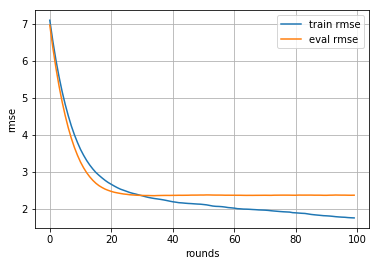

In [8]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

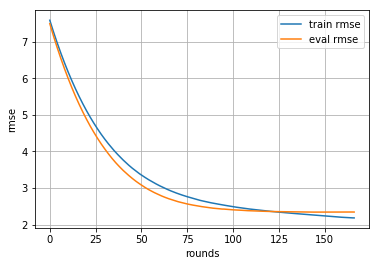

In [16]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

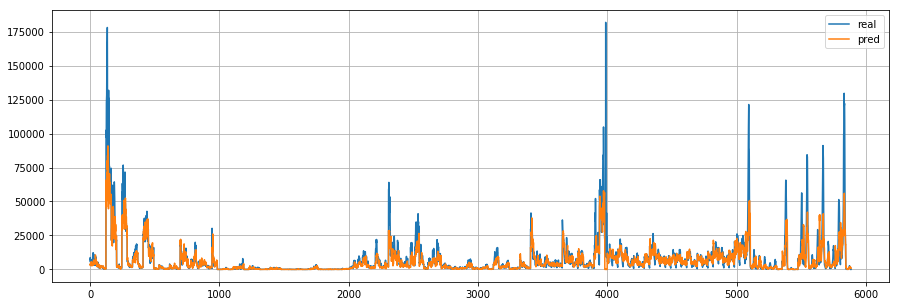

In [9]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Cost'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

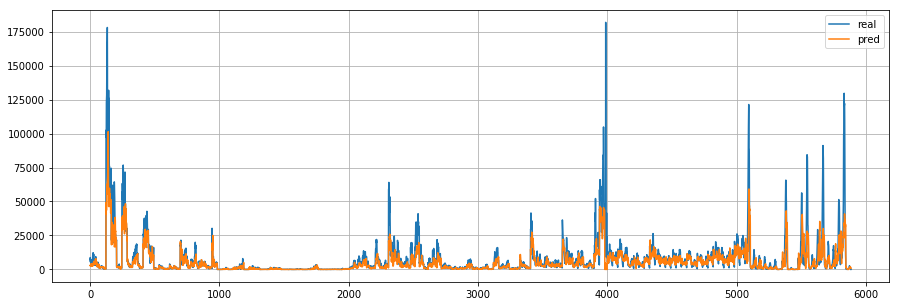

In [17]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Cost'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

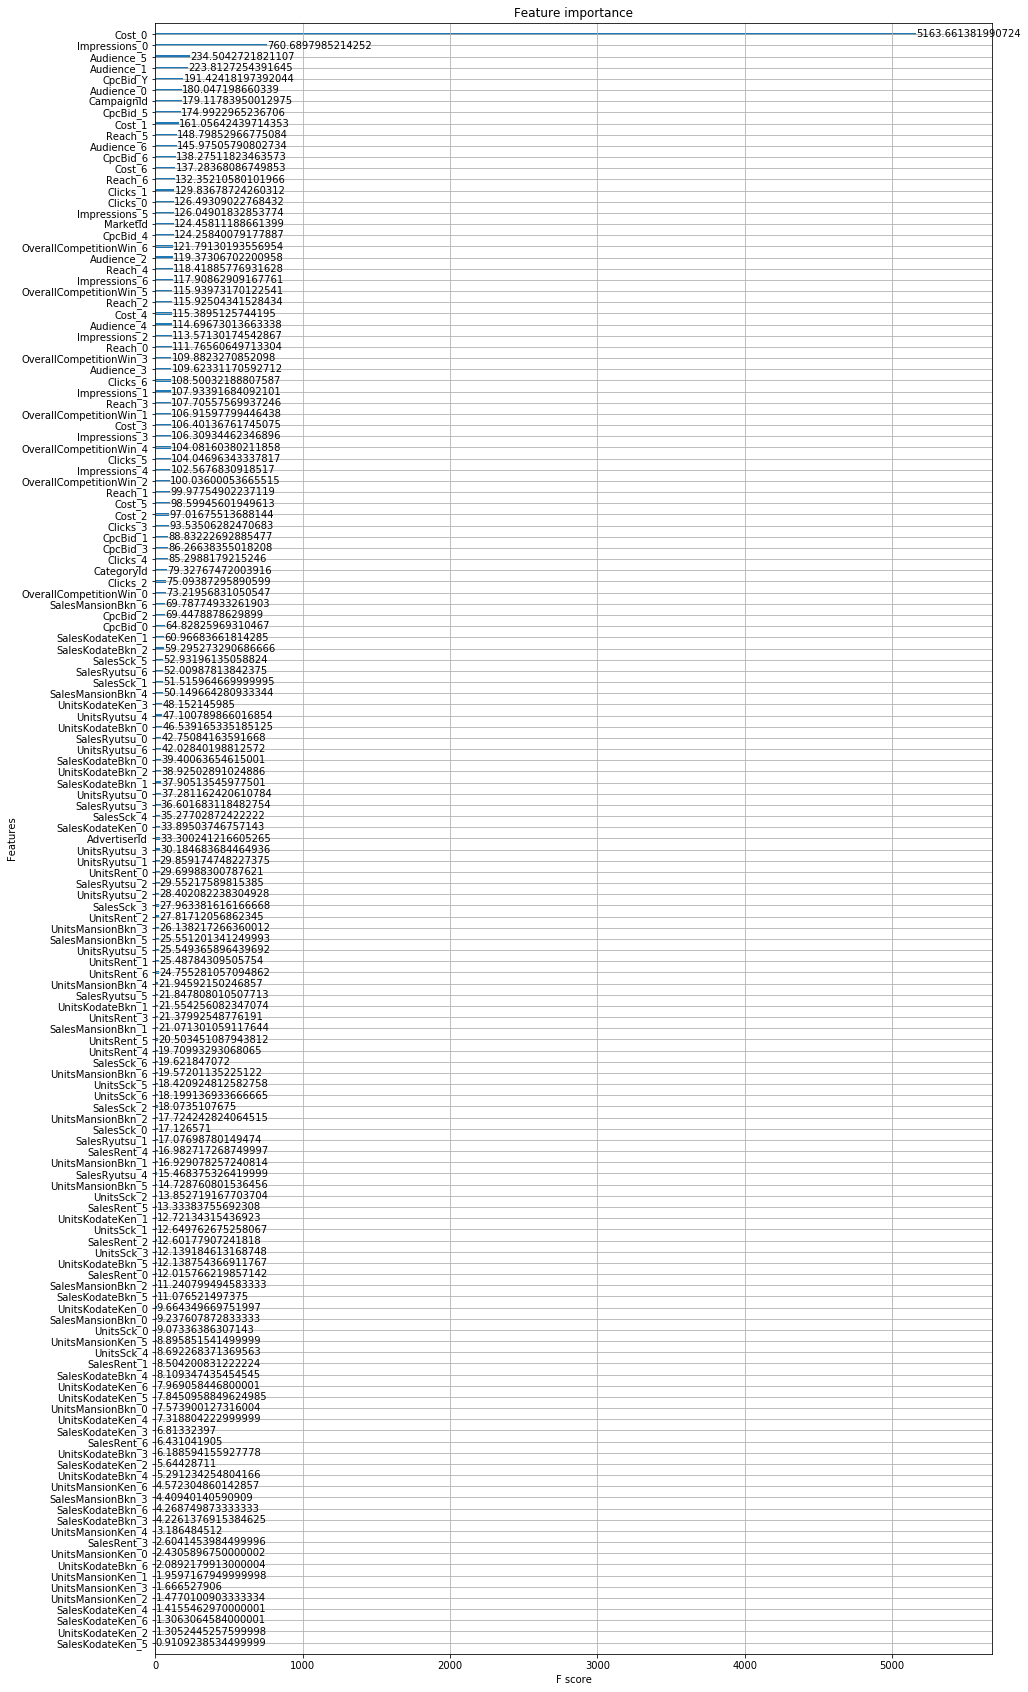

In [10]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [11]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['Cost_0',
 'Impressions_0',
 'Audience_5',
 'Audience_1',
 'CpcBid_Y',
 'Audience_0',
 'CampaignId',
 'CpcBid_5',
 'Cost_1',
 'Reach_5',
 'Audience_6',
 'CpcBid_6',
 'Cost_6',
 'Reach_6',
 'Clicks_1',
 'Clicks_0',
 'Impressions_5',
 'MarketId',
 'CpcBid_4',
 'OverallCompetitionWin_6',
 'Audience_2',
 'Reach_4',
 'Impressions_6',
 'OverallCompetitionWin_5',
 'Reach_2',
 'Cost_4',
 'Audience_4',
 'Impressions_2',
 'Reach_0',
 'OverallCompetitionWin_3',
 'Audience_3',
 'Clicks_6',
 'Impressions_1',
 'Reach_3',
 'OverallCompetitionWin_1',
 'Cost_3',
 'Impressions_3',
 'OverallCompetitionWin_4',
 'Clicks_5',
 'Impressions_4',
 'OverallCompetitionWin_2',
 'Reach_1',
 'Cost_5',
 'Cost_2',
 'Clicks_3',
 'CpcBid_1',
 'CpcBid_3',
 'Clicks_4',
 'CategoryId',
 'Clicks_2',
 'OverallCompetitionWin_0',
 'SalesMansionBkn_6',
 'CpcBid_2',
 'CpcBid_0',
 'SalesKodateKen_1',
 'SalesKodateBkn_2',
 'SalesSck_5',
 'SalesRyutsu_6',
 'SalesSck_1',
 'SalesMansionBkn_4',
 'UnitsKodateKen_3',
 'UnitsRyutsu_4',
 